# Machine Learning Project

Master 2 Financial Engineering \
by : \
Flora MARTIN - 74575 \
Guillaume IDAME KORALAGE - 73004 \
Raphael DUPONT - 72911 \
Louis ALVERGNE - 72711

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### Librairies

In [2]:
import numpy as np
import pandas as pd
import scipy as sc
from scipy import stats
from scipy.stats import chi2_contingency

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, r2_score, auc, roc_curve
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import itertools as it
import operator

import warnings
warnings.filterwarnings("ignore")

### Import Data from CSV

In [3]:
raw_data = pd.read_csv("data_training_Project_ML_Finance.csv")
raw_data.set_index("Day", inplace = True)
raw_data.dropna(inplace = True)

## Part A - AlgorithmicTrading System using Machine Learning

*Objective*\
Develop a trading algorithm that uses machine learning to predict stock price movements and make trading decisions.

*Rules*:\
•	You start wiith a portfolio worth 1Million (in Cash)\
•	Interest  rate = 0\
•	You can only go long on an integer number of stocks.\
•	You cannot borrow , neither go short.\
•	Before buying new stock, you need to first sale some other to have the cash (no direct stock conversion)\
•	There is only one price per day. At which you sell and buy.\
•	The last day you sell all your assets and get the cash.\


### Functions

#### Trading Metrics

In [4]:
def get_sharpe_ratio(df) : 
    frequency_return = df.pct_change()
    sharpe_ratio = np.sqrt(252) * frequency_return.mean() / frequency_return.std()
    return sharpe_ratio

def get_cumul_return(df) :
    frequency_return = df.pct_change()
    cumul_return = (1 + frequency_return).cumprod() - 1
    return cumul_return.dropna()

def get_volatility(df) : 
    frequency_return = df.pct_change()
    volatility = np.sqrt(252) * frequency_return.std()
    return volatility.dropna()

def get_maximum_drawdown(df, window) : 
    roll_max = df.rolling(window, min_periods=1).max()
    drawdown = df/roll_max - 1.0
    maximum_drawdown = drawdown.rolling(window, min_periods=1).min()
    return maximum_drawdown.dropna()

def get_hit_ratio(df) :
    frequency_return = df.pct_change()
    binary_change = frequency_return.mask(frequency_return > 0, 1).mask(frequency_return <= 0, -1).dropna()
    binary_count = binary_change.apply(pd.value_counts)
    hit_ratio = binary_count.iloc[1,:]/binary_count.sum()
    return hit_ratio

def get_skew_ratio(df) :
    hit_ratio = get_hit_ratio(df)
    skew_ratio = hit_ratio/(1 - hit_ratio)
    return skew_ratio

def get_rolling_sharpe(df, window) : 
    frequency_return = df.pct_change()
    rolling_sharpe =  np.sqrt(window) * frequency_return.rolling(window).mean() / frequency_return.rolling(window).std()
    return rolling_sharpe.dropna()

def get_rolling_volatility(df, window) : 
    frequency_return = df.pct_change()
    rolling_volatility = np.sqrt(window) * frequency_return.rolling(window).std()
    return rolling_volatility.dropna()

def get_average_profit(df) :
    frequency_return = df.pct_change()
    average_profit = frequency_return[frequency_return > 0].mean()
    return average_profit

def get_average_loss(df) : 
    frequency_return = df.pct_change()
    average_loss = frequency_return[frequency_return < 0].mean()
    return average_loss

def get_expectancy(df) :
    average_profit = get_average_profit(df)
    average_loss = get_average_loss(df)
    hit_ratio = get_hit_ratio(df)
    average_profit_per_trade = average_profit * hit_ratio - average_loss * (1 - hit_ratio)
    return average_profit_per_trade

def get_profit_to_drawdown_ratio(df, window) : 
    frequency_return = df.pct_change()
    average_return = frequency_return.mean()
    max_drawdown = get_maximum_drawdown(df, window).iloc[-1, :]
    profit_to_drawdown_ratio = average_return / max_drawdown
    return profit_to_drawdown_ratio
    
def get_calmar_ratio(df, window) : 
    cumul_return = get_cumul_return(df) 
    maximum_drawdown = get_maximum_drawdown(df, window)
    calmar_ratio = cumul_return / maximum_drawdown 
    return calmar_ratio

def get_conditional_sharpe(df, df_bmk, signal = "Negative"):
    conditional_sharpe = get_sharpe_ratio(df.loc[df_bmk[df_bmk == signal].index])
    return conditional_sharpe

def get_metrics(df, window) :
    sharpe_ratio = get_sharpe_ratio(df).to_frame(name = "Sharpe Ratio")
    cumul_return = get_cumul_return(df).iloc[-1, :].to_frame(name = "Cumul Return")
    volatility = get_volatility(df).to_frame(name = "Volatility")
    maximum_drawdown = get_maximum_drawdown(df, window).iloc[-1, :].to_frame(name = "Maximum Drawdown")
    hit_ratio = get_hit_ratio(df).to_frame(name = "Hit Ratio")
    skew_ratio = get_skew_ratio(df).to_frame(name = "Skew Ratio")
    average_profit = get_average_profit(df).to_frame(name = "Average Profit")
    average_loss = get_average_loss(df).to_frame(name = "Average Loss")
    expectancy = get_expectancy(df).to_frame(name = "Expectancy")
    profit_to_drawdown_ratio = get_profit_to_drawdown_ratio(df, window).to_frame(name = "Profit to drawndown")
    calmar_ratio = get_calmar_ratio(df, window).iloc[-1, :].to_frame(name = "Calmar Ratio")

    metrics = pd.concat([sharpe_ratio,
                        cumul_return,
                        volatility,
                        hit_ratio,
                        skew_ratio,
                        average_profit,
                        average_loss,
                        expectancy,
                        profit_to_drawdown_ratio,
                        calmar_ratio], axis = 1)
    
    return metrics

def get_portfolio_value(returns, cumulative = True):
    #initial value set to 1
    if cumulative:
        values = (1 + returns)
        return values.div(values.iloc[0])
    else:
        values = (1 + returns).cumprod()
        return(values.div(values.iloc[0]))

In [5]:
def get_correlation_timeseries(df, correlation_matrix, window_value) : 
    
    table_correl = correlation_matrix.unstack().to_frame(name = "Focus Correlation").dropna().drop_duplicates()
    tupple_correl = table_correl.index.tolist()
    correl_names = [item for t in tupple_correl for item in t]
    unique_correl_names = list(set(correl_names))
    
    df_select = df[unique_correl_names]

    res_select = pd.DataFrame()
    for pair in tupple_correl:
        # select the first three letters of each name of the pair
        corr_name = f"{pair[0][:3]}_{pair[1][:3]}_corr"
        res_select[corr_name] = df_select[list(pair)].\
                        rolling(window=window_value).\
                        corr().iloc[0::2, -1].reset_index(drop=True)

    return res_select


def plot_2_dataframes(df1, df2, title1, title2) : 
    fig, axs = plt.subplots(2,2, figsize = (15,8))
    fig.tight_layout(pad=5.0)

    #df1
    axs[0, 0].plot(df1, label =list(df1.columns))
    axs[0, 0].set_title(title1)
    axs[0, 0].set_xlabel("days")
    axs[0, 0].set_ylabel("Value")
    axs[0, 0].legend()
    axs[0, 0].grid()

    axs[1, 0].hist(df1, label = list(df1.columns), alpha = 0.7, bins = 50)
    axs[1, 0].set_title(title1)
    axs[1, 0].set_xlabel("Value")
    axs[1, 0].set_ylabel("Number of points")
    axs[1, 0].legend()
    axs[1, 0].grid()
    axs[1, 0].set_axisbelow(True)

    #df2
    axs[0, 1].plot(df2, label = list(df2.columns))
    axs[0, 1].set_title(title2)
    axs[0, 1].set_xlabel("days")
    axs[0, 1].set_ylabel("Value")
    axs[0, 1].legend()
    axs[0, 1].grid()
    
    axs[1, 1].hist(df2, label = list(df2.columns), alpha = 0.7, bins = 50)
    axs[1, 1].set_title(title2)
    axs[1, 1].set_xlabel("Value")
    axs[1, 1].set_ylabel("Number of points")
    axs[1, 1].legend()
    axs[1, 1].grid()
    axs[1, 1].set_axisbelow(True)

#### Systematic Trading Strategies

In [6]:
def get_positions_double_step(df, threshold1, threshold2) :
    
    positions_double_step = np.where(df > threshold2, -1, np.where(df < threshold1, 1, 0))
    long_positions_array = np.where(positions_double_step == 1, 1, 0)
    short_positions_array = np.where(positions_double_step == -1, -1, 0)

    long_positions_data = pd.DataFrame(long_positions_array, index = df.index, columns = df.columns)
    short_positions_data = pd.DataFrame(short_positions_array, index = df.index, columns = df.columns)
    
    return long_positions_data, short_positions_data

def get_positions_sigmoid(df, threshold) :
    
    threshold_sigmoid = 0.5
    sigmoid_df = 1 / (1 + np.exp(-df))
    positions_array = sigmoid_df - threshold

    long_positions_data = positions_array[positions_array > 0]
    short_positions_data = positions_array[positions_array <= 0]
    
    return long_positions_data, short_positions_data

def get_equally_weighted_positions(long_positions_data, short_positions_data) : 
    
    weighted_long_positions_data = long_positions_data / np.array(np.sum(long_positions_data, axis=1))[:, None]
    weighted_short_positions_data = short_positions_data / np.array(np.sum(short_positions_data, axis=1))[:, None]
    weighted_positions = weighted_short_positions_data.fillna(0) + weighted_long_positions_data.fillna(0)

    return weighted_positions

def get_weighted_vol(df, window) :
    inverse_variance = 1 / (np.sqrt(window) * df.rolling(window).std().dropna()) ** 2
    sum_inverse_variance = inverse_variance.sum(axis = 1).to_frame(name = "Sum Inverse Variance")
    weights = inverse_variance / sum_inverse_variance.values
    return weights

def get_vol_weighted_positions(long_positions_data, short_positions_data, df, window) : 
    
    vol_weighted = get_weighted_vol(df, window)
    long_vol_weighted = vol_weighted * long_positions_data
    short_vol_weighted = vol_weighted * short_positions_data

    weighted_short_positions_data = short_vol_weighted / short_vol_weighted.sum().values
    weighted_long_positions_data = long_vol_weighted / long_vol_weighted.sum().values
    weighted_positions = weighted_short_positions_data.fillna(0) + weighted_long_positions_data.fillna(0)

    return weighted_positions

def short_constraints(weighted_positions, short_possible = False) : 
    
    cumul_weighted_positions = weighted_positions.cumsum()
    cumul_weighted_positions_restricted = np.maximum(cumul_weighted_positions, short_possible)
    weighted_positions_restricted = cumul_weighted_positions_restricted.diff()    
    
    return weighted_positions_restricted

def bank_constraint(df, position, nominal = 1000000):
    #df.iloc[window-1:]
    position_values = df.multiply(position)
    for i in range(position_values.shape[0]):
        for j in range(position_values.shape[1]):
            if nominal - position_values.iloc[i,j] >= 0 :
                nominal -= position_values.iloc[i,j]
            else:
                position.iloc[i,j] = 0
    return(position)
    
def backtesting(positions, shift_positions, returns) :

    frequency_return = (positions.shift(shift_positions) * returns).dropna()
    cumul_return = (1 + frequency_return).cumprod() - 1
    
    return frequency_return, cumul_return

In [7]:
def eq_weighted_mean_reverting_double_step(df, window, threshold, nominal) :
    
    zscore_df = (df - df.rolling(window).mean()) / df.rolling(window).std()
    zscore_df_clean = zscore_df.dropna()
    
    long_positions_data, short_positions_data = get_positions_double_step(zscore_df_clean,  - threshold, threshold)
    weighted_positions = get_equally_weighted_positions(long_positions_data, short_positions_data)
    weighted_positions_restricted = short_constraints(weighted_positions)
    weighted_positions_restricted = bank_constraint(df.iloc[window-1:], weighted_positions_restricted, nominal)
    
    frequency_return, cumul_return = backtesting(weighted_positions_restricted, 1, df.pct_change())
    
    double_step_eq_portfolio_return = frequency_return.sum(axis = 1)
    double_step_eq_portfolio_cumul_return = (1 + double_step_eq_portfolio_return).cumprod() - 1
    double_step_eq_portfolio_cumul_return = double_step_eq_portfolio_cumul_return.to_frame(name = "Double Step - Eq weighted")
    
    return double_step_eq_portfolio_return, double_step_eq_portfolio_cumul_return


def vol_weighted_mean_reverting_double_step(df, window, threshold, nominal) :
    
    zscore_df = (df - df.rolling(window).mean()) / df.rolling(window).std()
    zscore_df_clean = zscore_df.dropna()
    
    long_positions_data, short_positions_data = get_positions_double_step(zscore_df_clean,  - threshold, threshold)
    weighted_positions = get_vol_weighted_positions(long_positions_data, short_positions_data, df, window)
    weighted_positions_restricted = short_constraints(weighted_positions)
    weighted_positions_restricted = bank_constraint(df.iloc[window-1:], weighted_positions_restricted, nominal)
    
    frequency_return, cumul_return = backtesting(weighted_positions_restricted, 1, df.pct_change())
    
    double_step_vol_portfolio_return = frequency_return.sum(axis = 1)
    double_step_vol_portfolio_cumul_return = (1 + double_step_vol_portfolio_return).cumprod() - 1
    double_step_vol_portfolio_cumul_return = double_step_vol_portfolio_cumul_return.to_frame(name = "Double Step - Vol weighted")
    
    return double_step_vol_portfolio_return, double_step_vol_portfolio_cumul_return

def eq_weighted_mean_reverting_sigmoid(df, window, threshold, nominal) :
    
    zscore_df = (df - df.rolling(window).mean()) / df.rolling(window).std()
    zscore_df_clean = zscore_df.dropna()
    
    long_positions_data, short_positions_data = get_positions_sigmoid(zscore_df_clean, threshold)
    weighted_positions = get_equally_weighted_positions(long_positions_data, short_positions_data)
    weighted_positions_restricted = short_constraints(weighted_positions)
    weighted_positions_restricted = bank_constraint(df.iloc[window-1:], weighted_positions_restricted, nominal)
    
    frequency_return, cumul_return = backtesting(weighted_positions_restricted, 1, df.pct_change())
    
    sigmoid_eq_portfolio_return = frequency_return.sum(axis = 1)
    sigmoid_eq_portfolio_cumul_return = (1 + sigmoid_eq_portfolio_return).cumprod() - 1
    sigmoid_eq_portfolio_cumul_return = sigmoid_eq_portfolio_cumul_return.to_frame(name = "Sigmoid - Eq weighted")
    
    return sigmoid_eq_portfolio_return, sigmoid_eq_portfolio_cumul_return

def vol_weighted_mean_reverting_sigmoid(df, window, threshold, nominal) :
    
    zscore_df = (df - df.rolling(window).mean()) / df.rolling(window).std()
    zscore_df_clean = zscore_df.dropna()
    
    long_positions_data, short_positions_data = get_positions_sigmoid(zscore_df_clean, threshold)
    weighted_positions = get_vol_weighted_positions(long_positions_data, short_positions_data, df, window)
    weighted_positions_restricted = short_constraints(weighted_positions)
    weighted_positions_restricted = bank_constraint(df.iloc[window-1:], weighted_positions_restricted, nominal)    
    frequency_return, cumul_return = backtesting(weighted_positions_restricted, 1, df.pct_change())
    
    sigmoid_vol_portfolio_return = frequency_return.sum(axis = 1)
    sigmoid_vol_portfolio_cumul_return = (1 + sigmoid_vol_portfolio_return).cumprod() - 1
    sigmoid_vol_portfolio_cumul_return = sigmoid_vol_portfolio_cumul_return.to_frame(name = "Sigmoid - Vol weighted")

    return sigmoid_vol_portfolio_return, sigmoid_vol_portfolio_cumul_return

In [8]:
def linear_regression(X_name, y_name, df, percentage_test) : 

    df_train, df_test = train_test_split(df, test_size = percentage_test, shuffle=False)
    X_train, X_test = df_train[X_name], df_test[X_name]
    y_train, y_test = df_train[y_name], df_test[y_name]

    reg = LinearRegression().fit(X_train.values.reshape(-1, 1), y_train.values.reshape(-1, 1))

    y_train = y_train.to_frame(name = "y Train")
    y_test = y_test.to_frame(name = "y Test")
    y_predict_train_array = reg.predict(X_train.values.reshape(-1, 1))
    y_predict_train = pd.DataFrame(y_predict_train_array, columns = ["y Predict Train"], index = y_train.index)
    y_predict_test_array = reg.predict(X_test.values.reshape(-1, 1))
    y_predict_test = pd.DataFrame(y_predict_test_array, columns = ["y Predict Test"], index = y_test.index)

    y_data = pd.concat([y_train, y_test, y_predict_train, y_predict_test], axis = 1) 

    return y_data


def metrics_linear_regression(X_name, y_name, df, percentage_test) : 
    
    #Regression
    y_data = linear_regression(X_name, y_name, df, percentage_test)
    
    #Pourcentage
    percentage_test_100 =  percentage_test * 100
    percentage_train_100 =  (1 - percentage_test) * 100
    
    #Residuals
    residuals_train = y_data["y Predict Train"] - y_data["y Train"]
    residuals_test = y_data["y Predict Test"] - y_data["y Test"]
    residuals_data = pd.concat([residuals_train, residuals_test], axis = 1)
    residuals_data.columns = [y_name + "_" + X_name + "_Residuals_Train", y_name + "_" + X_name + "_Residuals_Test"]
    
    #R2 Score
    r2_train = r2_score(y_data["y Train"].dropna(), y_data["y Predict Train"].dropna())
    r2_test = r2_score(y_data["y Test"].dropna(), y_data["y Predict Test"].dropna())
    r2_data = pd.DataFrame([r2_train, r2_test], columns = [y_name + "_" + X_name + "_R2"], index = ["R2_y_X Train_" + str(int(percentage_train_100)) + "%", "R2_y_X Test_" + str(int(percentage_test_100)) + "%"])
    
    return residuals_data, r2_data


def r2_correl_names(list_stocks_columns, percentage_test) : 
    
    r2_stocks = pd.DataFrame([])
    for list_y_X in list_stocks_columns : 
        y_name, X_name = list_y_X[0], list_y_X[1]
        df = clean_numerical_variable.pct_change().dropna()
        y_data = linear_regression(X_name, y_name, df, percentage_test)
        residuals_data, r2_data = metrics_linear_regression(X_name, y_name, df, percentage_test)
        r2_stocks = pd.concat([r2_stocks, r2_data], axis = 1)

    return r2_stocks


def residuals_correl_names(list_stocks_columns, percentage_test) : 
    
    residuals_stocks = pd.DataFrame([])
    for list_y_X in list_stocks_columns : 
        y_name, X_name = list_y_X[0], list_y_X[1]
        df = clean_numerical_variable.pct_change().dropna()
        y_data = linear_regression(X_name, y_name, df, percentage_test)
        residuals_data, r2_data = metrics_linear_regression(X_name, y_name, df, percentage_test)
        residuals_stocks = pd.concat([residuals_stocks, residuals_data], axis = 1)

    return residuals_stocks

In [9]:
def logistic_regression_auc(y, X, 
                        get_confusion_matrix = False, 
                        get_classification_report = False):
    #encoder
    label_encoder = LabelEncoder()
    X = label_encoder.fit_transform(X).reshape(-1, 1)
    y = label_encoder.fit_transform(y).reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle = False)
    model = linear_model.LogisticRegression(max_iter=1000)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    
    #confusion matrix
    if get_confusion_matrix:
        plt.figure(figsize=(8,6))
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()
    
    #classification report
    if get_classification_report:
        print(classification_report(y_test, y_pred))
    
    #AUC    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)
    return(round(auc(fpr, tpr),2))

    
def resampling(df, frequency_period = "Week", method = "last_value"):
    frequency_range = {"Day" : 1, "Week" : 5, "Month" : 22, "Year" : 252}
    if method == "last_value":
        return(pd.DataFrame(df.iloc[::frequency_range[frequency_period]].values, 
                               index = pd.Index(range(1, len (df.iloc[::frequency_range[frequency_period]]) +1), name = frequency_period),
                               columns = df.columns))
    elif method == "mean":
        return(pd.DataFrame(df.rolling(frequency_range[frequency_period], min_periods = 1).mean().iloc[::frequency_range[frequency_period]].values, 
                               index = pd.Index(range(1, len (df.iloc[::frequency_range[frequency_period]]) +1), name = frequency_period, columns = df.columns)))

def auc_stocks_logreg_resampled(y_df, x_df, frequency = ["Day", "Week", "Month"]):
    auc = {}
    for freq in frequency:
        x_df_resampled = resampling(x_df, frequency_period = freq)
        y_df_resampled = resampling(y_df, frequency_period = freq)
        auc[freq] = [logistic_regression_auc(y_df_resampled[col].pct_change().dropna().apply(lambda x: "Positive" if x > 0 else "Negative"), x_df_resampled.iloc[1:]) for col in y_df_resampled.columns]
    return(pd.DataFrame(auc, index = y_df.columns, columns = frequency))

### I - Data Preprocessing

#### Separate Data by types

In [10]:
categorical_variable = raw_data.loc[:, raw_data.dtypes == object]
numerical_variable = raw_data.loc[:, raw_data.dtypes == float]

#### 1) Numerical Data - Analysis

Description of the dataset (count, mean, std, min, 25%, 50%, 75%, max) 

In [11]:
numerical_variable_describe = numerical_variable.describe()
numerical_variable_describe

ABC          MKV         YYT         PLO         ERS         HUY  \
count  749.000000  749.000000  749.000000  749.000000  749.000000  749.000000   
mean   117.562830   65.181202   50.898652   18.295714   65.593738   75.125327   
std      7.778703    5.227588   15.180599    2.692507    0.719858    1.470209   
min     99.730000   54.940000   28.890000   12.810000   63.740000   71.550000   
25%    110.170000   59.450000   34.470000   16.730000   65.260000   74.620000   
50%    120.170000   67.320000   54.790000   17.650000   65.650000   75.510000   
75%    123.210000   68.780000   64.830000   19.740000   66.070000   76.020000   
max    130.200000   73.540000   78.050000   26.090000   67.340000   78.130000   

             MON          AQE         IX50  
count  749.000000  749.000000   749.000000  
mean    31.783458   22.903458  1380.214553  
std      0.151976    0.166925   181.215404  
min     31.560000   22.660000    -1.000000  
25%     31.660000   22.760000  1277.920000  
50%     31.710000   22.860000  1303.970000  
75%     31.940000   23.080000  1454.040000  
max     32.080000   23.230000  1833.020000

Z-scores for the dataset

In [12]:
stats.zscore(numerical_variable).describe().style.background_gradient(cmap='RdYlGn', axis = 1)

Plot each timeseries to have an overview of the numerical data with removing outliers

array([[<Axes: xlabel='Day'>, <Axes: xlabel='Day'>, <Axes: xlabel='Day'>],
       [<Axes: xlabel='Day'>, <Axes: xlabel='Day'>, <Axes: xlabel='Day'>],
       [<Axes: xlabel='Day'>, <Axes: xlabel='Day'>, <Axes: xlabel='Day'>]],
      dtype=object)

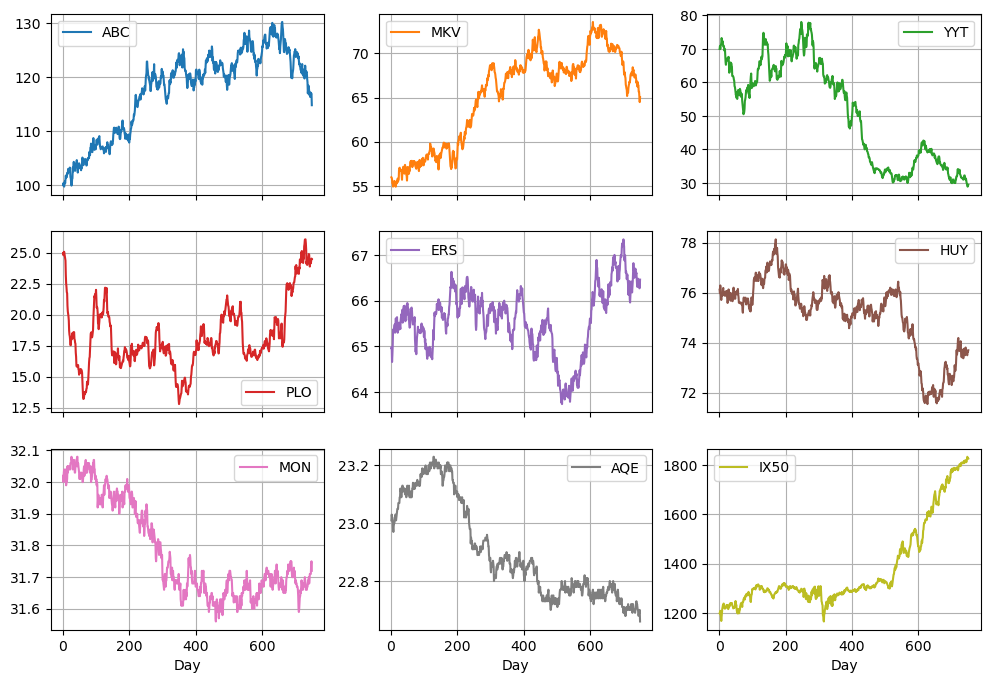

In [13]:
clean_numerical_variable = numerical_variable[(np.abs(stats.zscore(numerical_variable)) < 3).all(axis=1)]
list_stocks_names = list(clean_numerical_variable.columns)
clean_numerical_variable.columns = [stock_name.replace(' ', '') for stock_name in list_stocks_names]
clean_numerical_variable.plot(subplots = True, layout = (3,3), figsize = (12,8), grid = True)

Data Visualization to check the relationships between each variable and the distribution

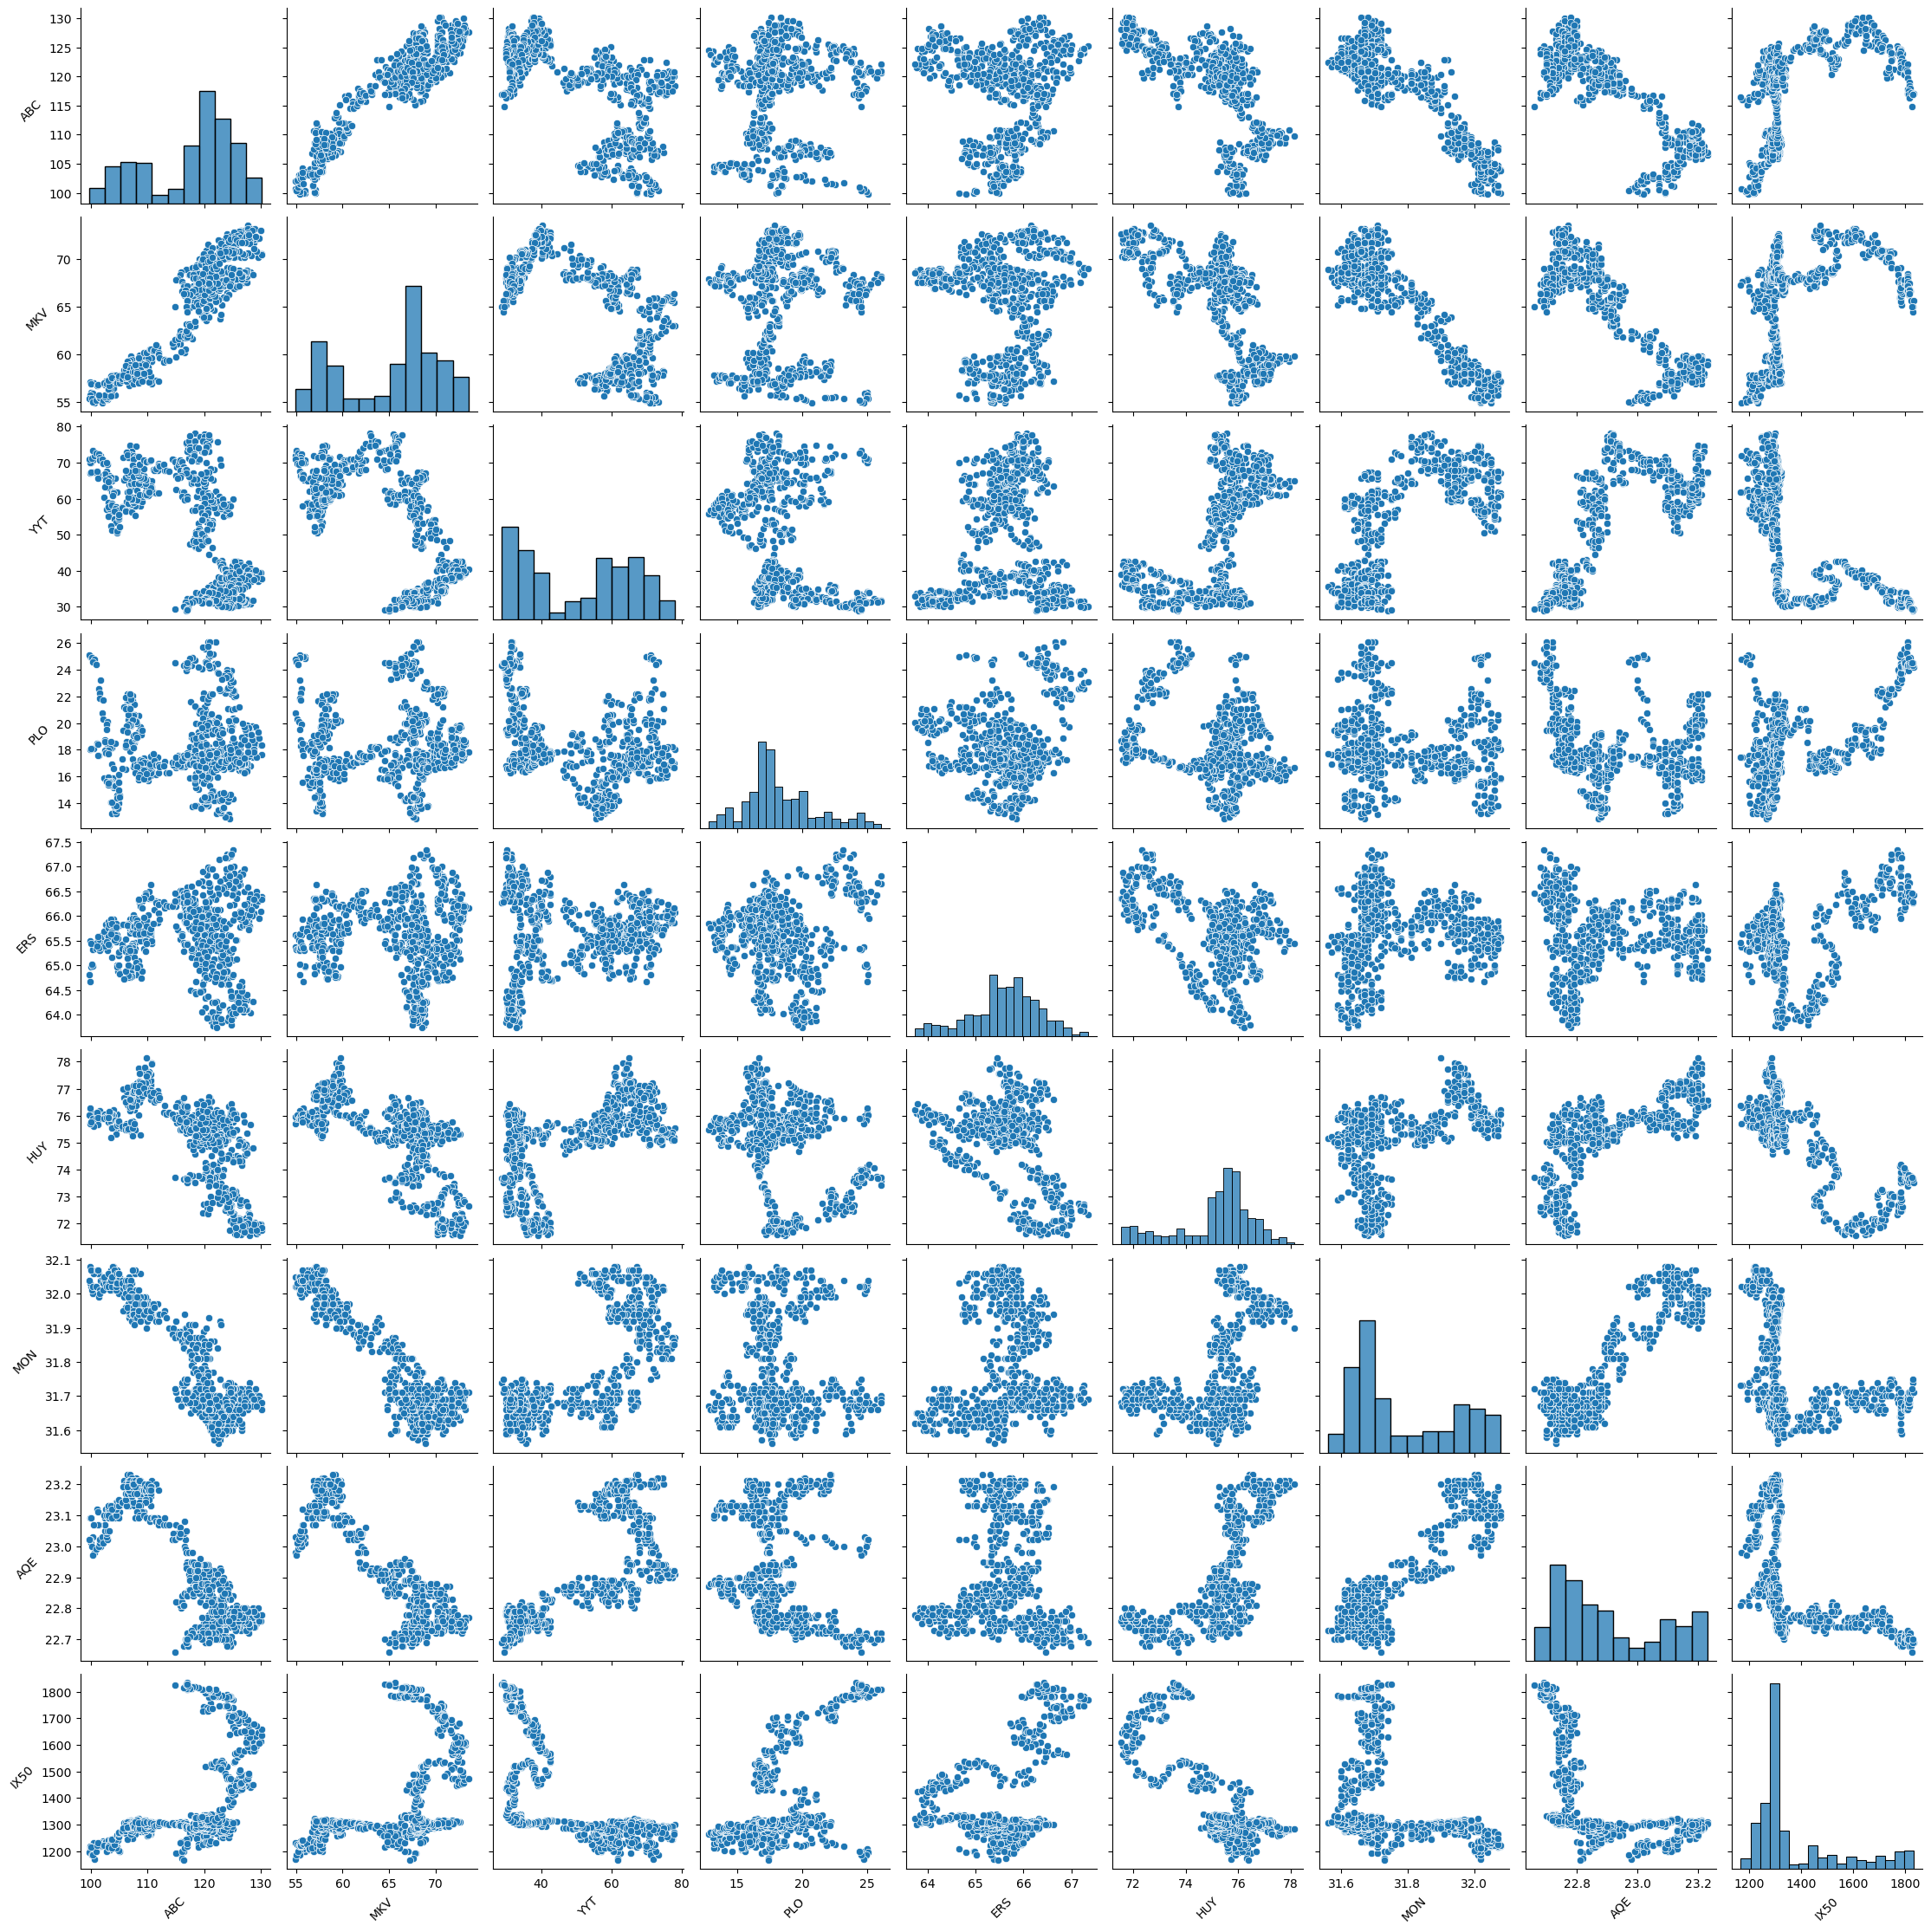

In [14]:
g = sns.pairplot(clean_numerical_variable, kind="scatter")
for ax in g.axes.flatten():
    # rotate x axis labels
    ax.set_xlabel(ax.get_xlabel(), rotation = 45)
    # rotate y axis labels
    ax.set_ylabel(ax.get_ylabel(), rotation = 45)
    # set y labels alignment
    ax.yaxis.get_label().set_horizontalalignment('right')

Data Visualization with a Correlation Matrix

In [15]:
# Compute the correlation matrix
numerical_corr = clean_numerical_variable.pct_change().corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(numerical_corr, dtype=bool))

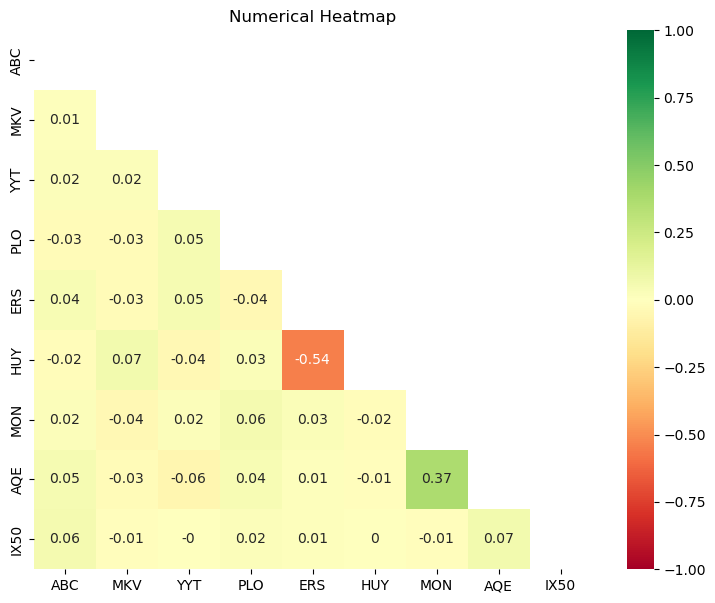

In [16]:
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(9, 7))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(numerical_corr.round(2), mask=mask, annot = True, cmap="RdYlGn", vmax = 1, vmin = -1)
ax.set_title("Numerical Heatmap")
plt.show()

#### Correlation Studies

##### Static Correlation 

In [17]:
threshold_correl = 0.1
positive_correl = numerical_corr[(numerical_corr > threshold_correl) & (numerical_corr < 1)]
negative_correl = numerical_corr[(numerical_corr < - threshold_correl) & (numerical_corr > - 1)]

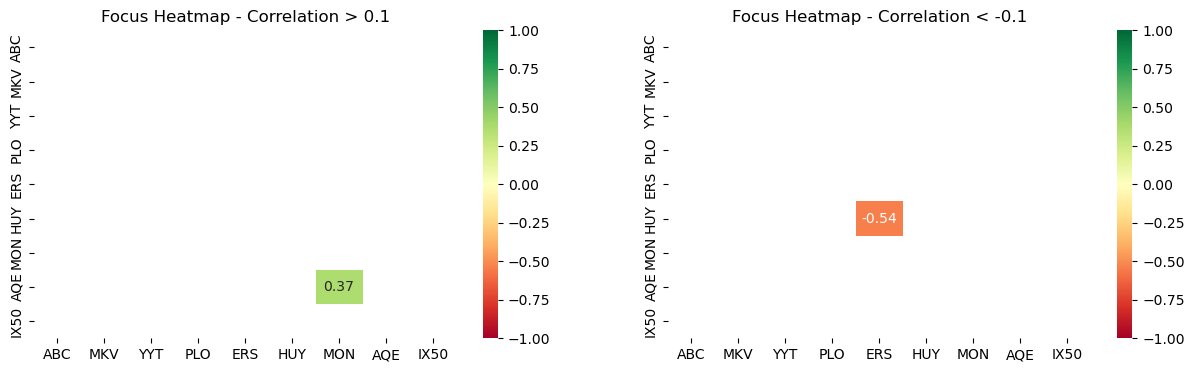

In [18]:
# Set up the matplotlib figure
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(positive_correl.round(2), mask=mask, annot = True, cmap="RdYlGn", vmax = 1, vmin = -1, ax = axs[0])
axs[0].set_title("Focus Heatmap - Correlation > "+str(threshold_correl))

sns.heatmap(negative_correl.round(2), mask=mask, annot = True, cmap="RdYlGn", vmax = 1, vmin = -1, ax = axs[1])
axs[1].set_title("Focus Heatmap - Correlation < -"+str(threshold_correl))

plt.show()

##### Rolling Correlation 

In [19]:
window_value = 10
res_positive = get_correlation_timeseries(clean_numerical_variable, positive_correl, window_value)
res_negative = get_correlation_timeseries(clean_numerical_variable, negative_correl, window_value)

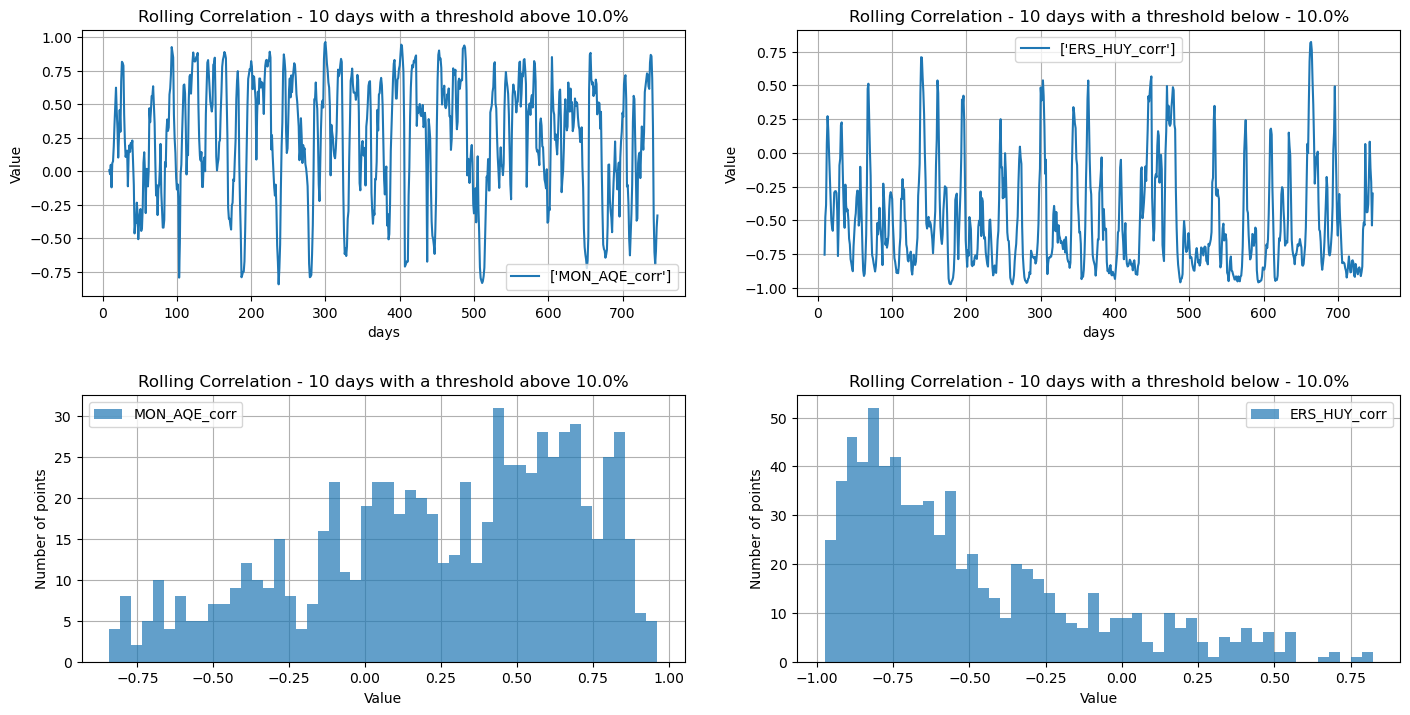

In [20]:
df1 = res_positive
df2 = res_negative
title1 = "Rolling Correlation - " + str(window_value) +" days with a threshold above " + str(threshold_correl*100)  + "%"
title2 = "Rolling Correlation - " + str(window_value) +" days with a threshold below - " + str(threshold_correl*100)  + "%"
plot_2_dataframes(df1, df2, title1, title2)

We see that : when we plot the rolling correlation of the highest and lowest static correlation, the rolling correlation is not stable through time. 
Thus, we can create systematic strategies on selling high correl and buy low correl.

#### Volatility Studies

Rolling volatility for every stock over a 60-day window

array([[<Axes: xlabel='Day'>, <Axes: xlabel='Day'>, <Axes: xlabel='Day'>],
       [<Axes: xlabel='Day'>, <Axes: xlabel='Day'>, <Axes: xlabel='Day'>],
       [<Axes: xlabel='Day'>, <Axes: xlabel='Day'>, <Axes: xlabel='Day'>]],
      dtype=object)

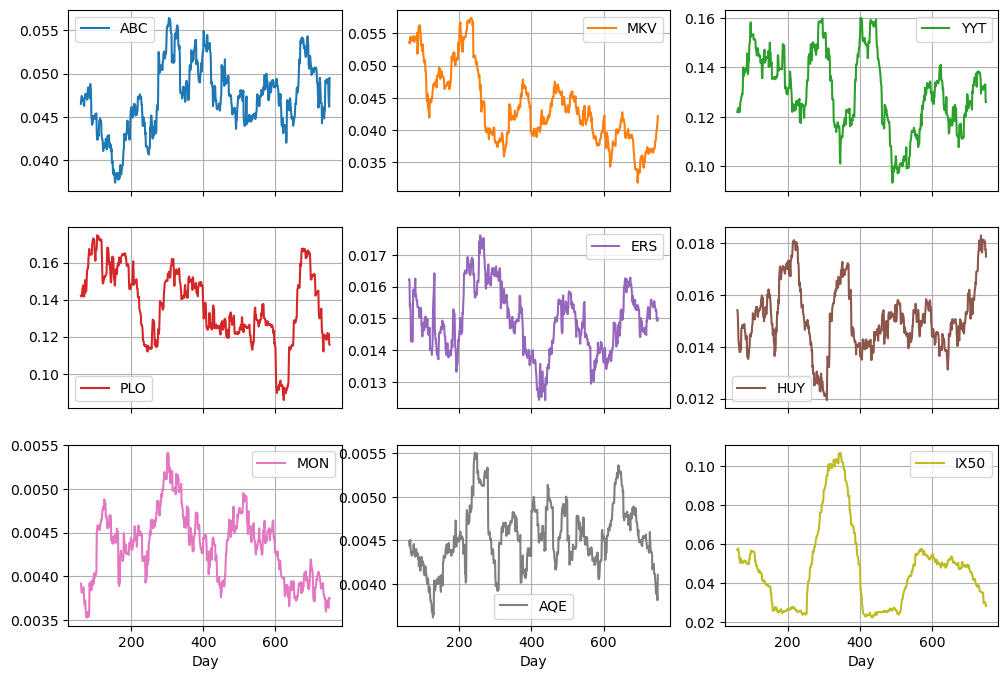

In [21]:
window_value = 60
rolling_vol_numerical_variable = np.sqrt(window_value) * clean_numerical_variable.pct_change().rolling(window_value).std().dropna()
rolling_vol_numerical_variable.plot(subplots = True, layout = (3,3), figsize = (12,8), grid = True)

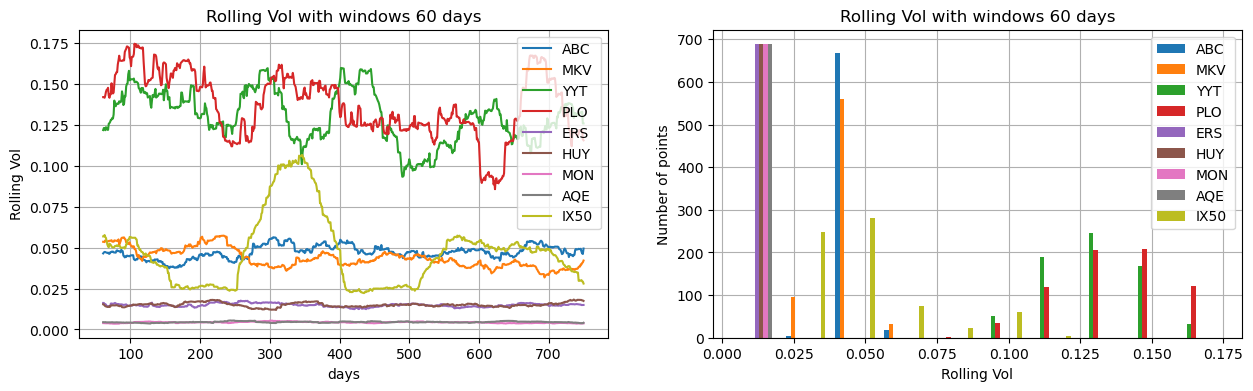

In [22]:
fig, axs = plt.subplots(1, 2, figsize = (15,4))

axs[0].plot(rolling_vol_numerical_variable, label = rolling_vol_numerical_variable.columns)
axs[0].set_title("Rolling Vol with windows " + str(window_value) + " days")
axs[0].set_xlabel("days")
axs[0].set_ylabel("Rolling Vol")
axs[0].legend()
axs[0].grid()

axs[1].hist(rolling_vol_numerical_variable, label = rolling_vol_numerical_variable.columns, bins = 10)
axs[1].set_title("Rolling Vol with windows " + str(window_value) + " days")
axs[1].set_xlabel("Rolling Vol")
axs[1].set_ylabel("Number of points")
axs[1].legend()
axs[1].grid()
axs[1].set_axisbelow(True)

We see that generally there are 3 types of stocks : Low Vol, Medium Vol, High Vol. 

#### 2) Categorical Data - Analysis

In [23]:
clean_categorical_variable = categorical_variable[categorical_variable["Weekday"] != "?"].replace("Thurday","Thursday").replace("thursday","Thursday")

**Cross Table of MacroEnvironment (either Positive, Neutral, or Negative) per weekday**

In [24]:
CrossTabResult = pd.crosstab(index = clean_categorical_variable["Macro Environment"], columns = clean_categorical_variable["Weekday"])
CrossTabResult

Weekday            Friday  Monday  Thursday  Tuesday  Wednesday
Macro Environment                                              
Negative               20      20        20       20         20
Neutral                70      70        70       70         70
Positive               59      60        59       60         60

**Correlation between Weekdays and Macro Environment**

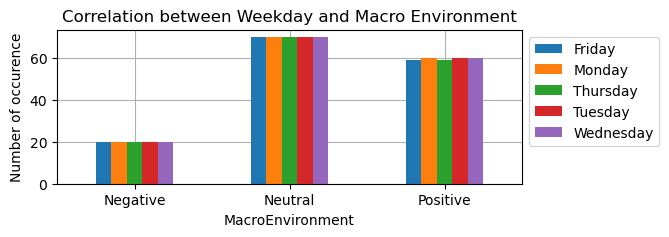

In [25]:
fig, ax = plt.subplots(figsize = (6,2))
CrossTabResult.plot.bar(ax = ax, rot = 0)
ax.set_title("Correlation between Weekday and Macro Environment")
ax.set_xlabel("MacroEnvironment")
ax.set_ylabel("Number of occurence")
ax.grid()
ax.legend(loc = "upper left", bbox_to_anchor=(1, 1))
ax.set_axisbelow(True)

We see that there are the same occurence of Negative/Neutral/Positive MacroEnvironment for each weekday.
Thus, there is no link between weekdays and macroenvironment.

#### 3) Numerical & Categorical Data - Cross Analysis

In [26]:
daily_return_clean_numerical_variable = clean_numerical_variable.pct_change().dropna()
dollar_portfolio = (1 + daily_return_clean_numerical_variable).cumprod()
resample_return = (dollar_portfolio / dollar_portfolio.shift(1)) - 1

In [27]:
numerical_variable_return = resample_return.dropna()
numerical_variable_return_mask = numerical_variable_return.mask(numerical_variable_return == 0, "Neutral Change").mask(numerical_variable_return < 0, "Negative Change").mask(numerical_variable_return > 0, "Positive Change")

#### Analysis Change according to Negative/Neutral/Positive Macro Environement

The aim is to cluster the change based on each MacroEnvironment state and see if there is any correlation.

In [28]:
multiindex_crosstab = {}
for numerical_column in numerical_variable_return_mask.columns : 
    crosstab = pd.crosstab(index = clean_categorical_variable["Macro Environment"], columns = numerical_variable_return_mask[numerical_column])
    multiindex_crosstab[numerical_column] = crosstab
    
multiindex_crosstab_data = pd.concat(multiindex_crosstab.values(), keys=multiindex_crosstab.keys())

In [29]:
macro_multiindex_crosstab_data = multiindex_crosstab_data.swaplevel(1, 0, axis = 0).sort_index()
neg_macro_crosstab = macro_multiindex_crosstab_data.xs("Negative", axis = 0, drop_level = True)
neutral_macro_crosstab = macro_multiindex_crosstab_data.xs("Neutral", axis = 0, drop_level = True)
pos_macro_crosstab = macro_multiindex_crosstab_data.xs("Positive", axis = 0, drop_level = True)

Text(0, 0.5, 'Number of occurence')

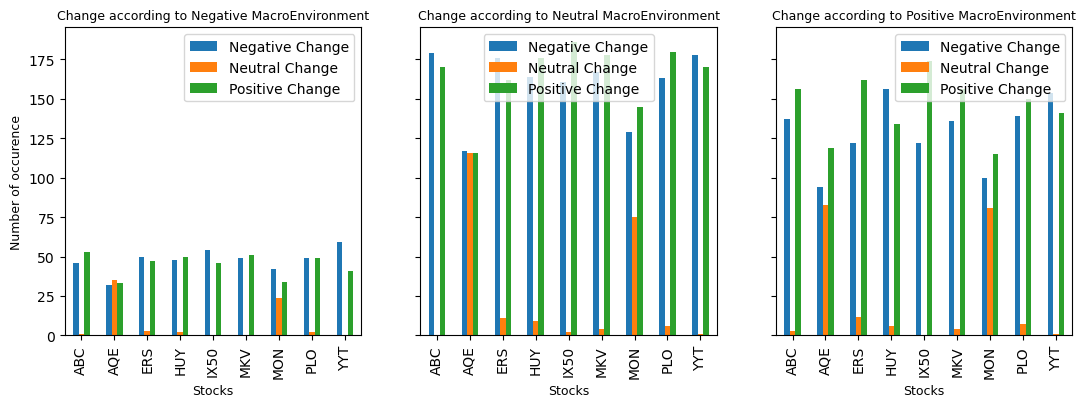

In [30]:
fig, axs = plt.subplots(1, 3, figsize = (13, 4), sharex='all', sharey='all')

#Focus Neg Macro
neg_macro_crosstab.plot(kind = "bar", ax = axs[0])
axs[0].set_title("Change according to Negative MacroEnvironment", fontsize = 9)
axs[0].set_xlabel("Stocks", fontsize = 9)
axs[0].set_ylabel("Number of occurence", fontsize = 9)
#Focus Neutral Macro
neutral_macro_crosstab.plot(kind = "bar", ax = axs[1])
axs[1].set_title("Change according to Neutral MacroEnvironment", fontsize = 9)
axs[1].set_xlabel("Stocks", fontsize = 9)
axs[1].set_ylabel("Number of occurence", fontsize = 9)
#Focus Pos Macro
pos_macro_crosstab.plot(kind = "bar", ax = axs[2])
axs[2].set_title("Change according to Positive MacroEnvironment", fontsize = 9)
axs[2].set_xlabel("Stocks", fontsize = 9)
axs[2].set_ylabel("Number of occurence", fontsize = 9)

We see that :\
Negative MacroEnvironment
- Negatively affected (significant) to the current MacroEnvironment : ERS, IX50, YTT
- Positively affected (significant) to the current MacroEnvironment : ABC, MKV

Positive MacroEnvironment
- Negatively affected (significant) to the current MacroEnvironment : HUY, YTT
- Positively affected (significant) to the current MacroEnvironment : ABC, ERS, IX50, MKV, PLO

#### Analysis Macro Environement according to Negative/Neutral/Positive Change

In [31]:
change_multiindex_crosstab_data = multiindex_crosstab_data.unstack(level = 0)
neg_change_crosstab = change_multiindex_crosstab_data.xs("Negative Change", axis = 1, drop_level = True).T
neutral_change_crosstab = change_multiindex_crosstab_data.xs("Neutral Change", axis = 1, drop_level = True).T
pos_change_crosstab = change_multiindex_crosstab_data.xs("Positive Change", axis = 1, drop_level = True).T

Text(0, 0.5, 'Number of occurence')

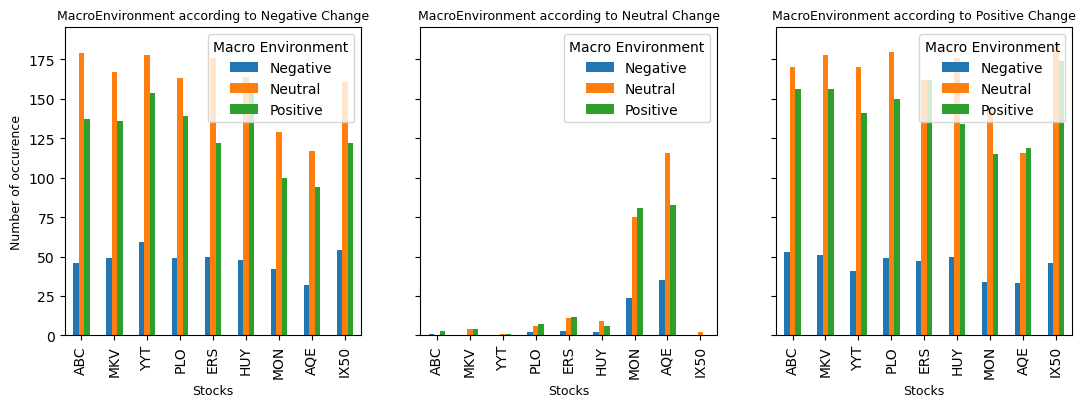

In [32]:
#Focus Neg Change
fig, axs = plt.subplots(1, 3, figsize = (13, 4), sharex='all', sharey='all')

neg_change_crosstab.plot(kind = "bar", ax = axs[0])
axs[0].set_title("MacroEnvironment according to Negative Change", fontsize = 9)
axs[0].set_xlabel("Stocks", fontsize = 9)
axs[0].set_ylabel("Number of occurence", fontsize = 9)
#Focus Neutral Change
neutral_change_crosstab.plot(kind = "bar", ax = axs[1])
axs[1].set_title("MacroEnvironment according to Neutral Change", fontsize = 9)
axs[1].set_xlabel("Stocks", fontsize = 9)
axs[1].set_ylabel("Number of occurence", fontsize = 9)
#Focus Pos Change
pos_change_crosstab.plot(kind = "bar", ax = axs[2])
axs[2].set_title("MacroEnvironment according to Positive Change", fontsize = 9)
axs[2].set_xlabel("Stocks", fontsize = 9)
axs[2].set_ylabel("Number of occurence", fontsize = 9)

We cannot deduce from the following bar charts any pieces of information.

#### Analysis Change according to differents days (Monday/Tuesday/Wednesday/Thursday/Friday)

In [33]:
multiindex_crosstab = {}
for numerical_column in numerical_variable_return_mask.columns : 
    crosstab = pd.crosstab(index = clean_categorical_variable["Weekday"], columns = numerical_variable_return_mask[numerical_column])
    multiindex_crosstab[numerical_column] = crosstab
    
multiindex_crosstab_data = pd.concat(multiindex_crosstab.values(), keys=multiindex_crosstab.keys())

In [34]:
weekday_multiindex_crosstab_data = multiindex_crosstab_data.swaplevel(1, 0, axis = 0).sort_index()
monday_crosstab = weekday_multiindex_crosstab_data.xs("Monday", axis = 0, drop_level = True)
tuesday_crosstab = weekday_multiindex_crosstab_data.xs("Tuesday", axis = 0, drop_level = True)
wednesday_crosstab = weekday_multiindex_crosstab_data.xs("Wednesday", axis = 0, drop_level = True)
thursday_crosstab = weekday_multiindex_crosstab_data.xs("Thursday", axis = 0, drop_level = True)
friday_crosstab = weekday_multiindex_crosstab_data.xs("Friday", axis = 0, drop_level = True)

Text(0, 0.5, 'Number of occurence')

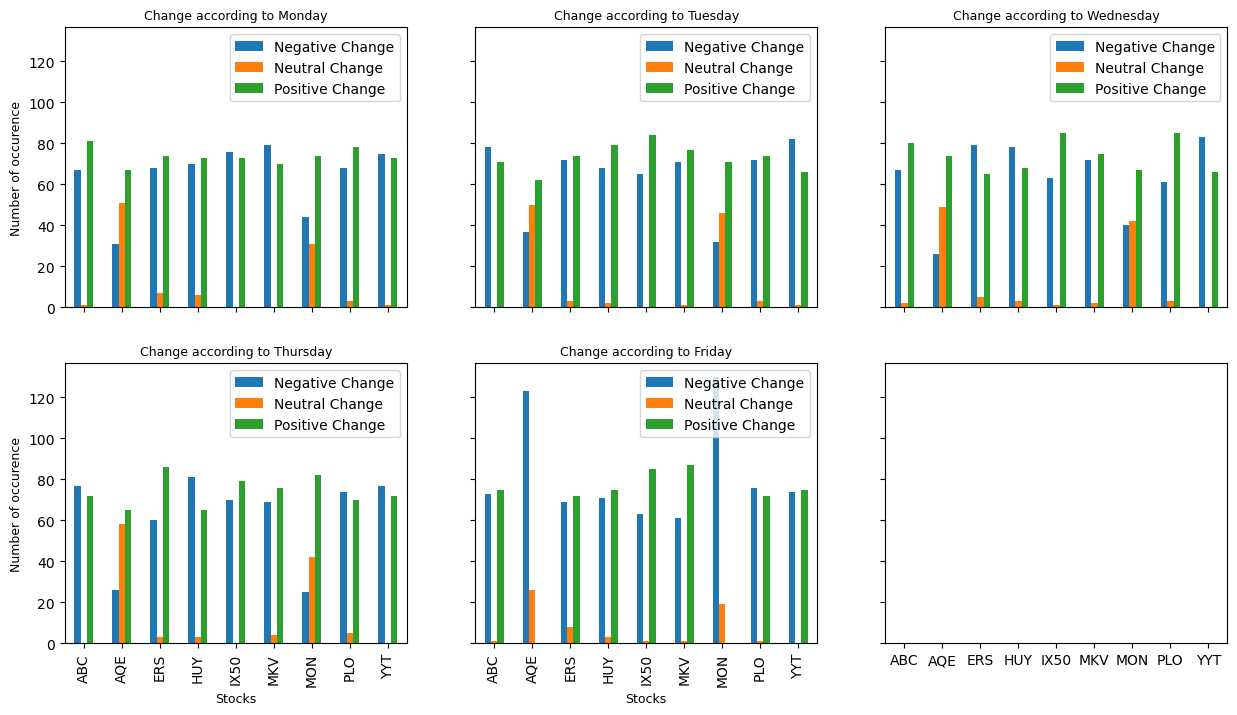

In [35]:
fig, axs = plt.subplots(2, 3, figsize = (15, 8), sharex='all', sharey='all')

monday_crosstab.plot(kind = "bar", ax = axs[0,0])
axs[0, 0].set_title("Change according to Monday", fontsize = 9)
axs[0, 0].set_xlabel("Stocks", fontsize = 9)
axs[0, 0].set_ylabel("Number of occurence", fontsize = 9)

tuesday_crosstab.plot(kind = "bar", ax = axs[0,1])
axs[0, 1].set_title("Change according to Tuesday", fontsize = 9)
axs[0, 1].set_xlabel("Stocks", fontsize = 9)
axs[0, 1].set_ylabel("Number of occurence", fontsize = 9)

wednesday_crosstab.plot(kind = "bar", ax = axs[0,2])
axs[0, 2].set_title("Change according to Wednesday", fontsize = 9)
axs[0, 2].set_xlabel("Stocks", fontsize = 9)
axs[0, 2].set_ylabel("Number of occurence", fontsize = 9)

thursday_crosstab.plot(kind = "bar", ax = axs[1,0])
axs[1, 0].set_title("Change according to Thursday", fontsize = 9)
axs[1, 0].set_xlabel("Stocks", fontsize = 9)
axs[1, 0].set_ylabel("Number of occurence", fontsize = 9)

friday_crosstab.plot(kind = "bar", ax = axs[1,1])
axs[1, 1].set_title("Change according to Friday", fontsize = 9)
axs[1, 1].set_xlabel("Stocks", fontsize = 9)
axs[1, 1].set_ylabel("Number of occurence", fontsize = 9)

We see that :\
Monday
- Negatively affected (significant) to the current day : MKV
- Positively affected (significant) to the current day : ABC, ERS, PLO

Tuesday
- Negatively affected (significant) to the current day : ABC, YYT
- Positively affected (significant) to the current day : HUY, IX50

Wednesday
- Negatively affected (significant) to the current day : YTT, ERS, HUY
- Positively affected (significant) to the current day : ABC, IX50, PLO

Thursday
- Negatively affected (significant) to the current day : HUY
- Positively affected (significant) to the current day : ERS, IX50, MKV

Friday
- Negatively affected (significant) to the current day : AQE, MON
- Positively affected (significant) to the current day : IX50, MKV

#### Analysis Days according to Negative/Neutral/Positive Change

In [36]:
change_multiindex_crosstab_data = multiindex_crosstab_data.unstack(level = 0)
neg_change_crosstab = change_multiindex_crosstab_data.xs("Negative Change", axis = 1, drop_level = True).T
neutral_change_crosstab = change_multiindex_crosstab_data.xs("Neutral Change", axis = 1, drop_level = True).T
pos_change_crosstab = change_multiindex_crosstab_data.xs("Positive Change", axis = 1, drop_level = True).T

Text(0, 0.5, 'Number of occurence')

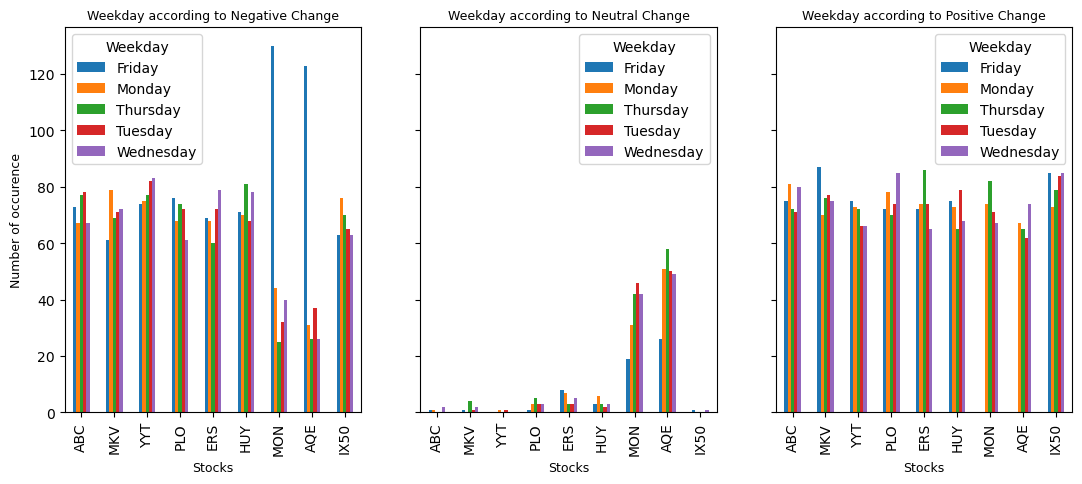

In [37]:
fig, axs = plt.subplots(1, 3, figsize = (13, 5), sharex='all', sharey='all')

#Focus Neg Change
neg_change_crosstab.plot(kind = "bar", ax = axs[0])
axs[0].set_title("Weekday according to Negative Change", fontsize = 9)
axs[0].set_xlabel("Stocks", fontsize = 9)
axs[0].set_ylabel("Number of occurence", fontsize = 9)
#Focus Neutral Change
neutral_change_crosstab.plot(kind = "bar", ax = axs[1])
axs[1].set_title("Weekday according to Neutral Change", fontsize = 9)
axs[1].set_xlabel("Stocks", fontsize = 9)
axs[1].set_ylabel("Number of occurence", fontsize = 9)
#Focus Pos Change
pos_change_crosstab.plot(kind = "bar", ax = axs[2])
axs[2].set_title("Weekday according to Positive Change", fontsize = 9)
axs[2].set_xlabel("Stocks", fontsize = 9)
axs[2].set_ylabel("Number of occurence", fontsize = 9)

We see that there are some skewness in the data for some stocks in weekdays :\
Negative Change 
- MON & AQE

#### Benchmark Equally Weighted and Vol Weighted Portfolios

We build two benchmarks using the whole portfolio of stocks and different ways of weighting:
 - Equally Weighted Benchmarks allocates the same proportion to every stock, regardless their performance or their risk
 - the Vol Weighted Benchmark gives to every stock a weight conversely proportional to its volatility, to get an adjusted-to-risk allocation

In [38]:
#Daily return of different stocks
daily_return_assets = clean_numerical_variable.pct_change().dropna()
#Cumul return of different stocks
cumul_return_assets = (1 + daily_return_assets).cumprod() - 1

In [39]:
#Daily return of equally weighted portfolio
daily_return_eq_weighted_ptf = daily_return_assets.mean(axis = 1).to_frame(name = "Daily Return Equally Weighted")
#Cumul return of equally weighted portfolio
cumul_return_eq_weighted_ptf = cumul_return_assets.mean(axis = 1).to_frame(name = "Benchmark - Equally Weighted")

In [40]:
window = 252
weights = get_weighted_vol(clean_numerical_variable, window) 
#Daily return of vol weighted portfolio
daily_return_vol_weighted_assets = weights * daily_return_assets
daily_return_vol_weighted_ptf = daily_return_vol_weighted_assets.dropna().sum(axis = 1).to_frame(name = "Daily Return Vol Weighted")
#Cumul return of vol weighted portfolio
cumul_return_vol_weighted_assets = (1 + daily_return_vol_weighted_assets).cumprod() - 1
cumul_return_vol_weighted_ptf = cumul_return_vol_weighted_assets.dropna().sum(axis = 1).to_frame(name = "Benchmark - Vol Weighted")

In [41]:
daily_return_benchmarks = pd.concat([daily_return_eq_weighted_ptf, daily_return_vol_weighted_ptf], axis = 1)
cumul_return_benchmarks = pd.concat([cumul_return_eq_weighted_ptf, cumul_return_vol_weighted_ptf], axis = 1)

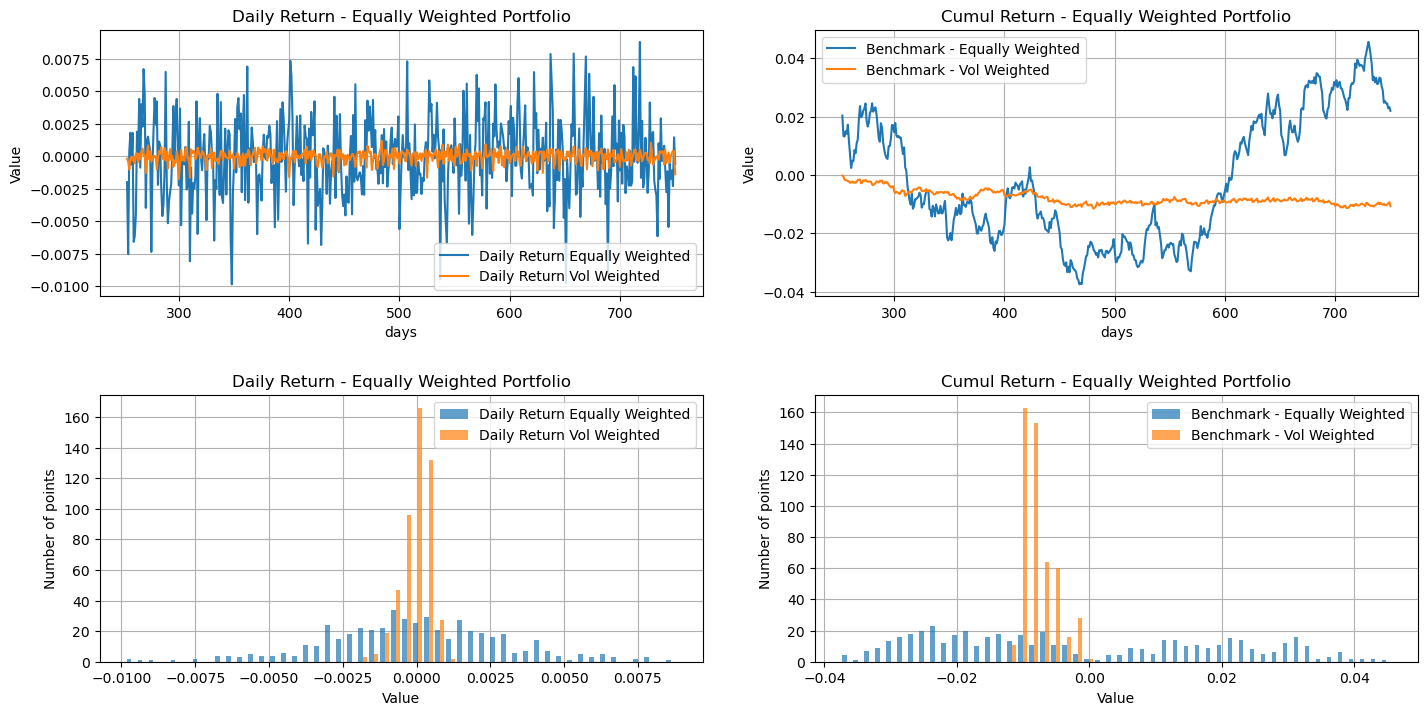

In [42]:
df1 = daily_return_benchmarks.dropna()
df2 = cumul_return_benchmarks.dropna()
title1 = "Daily Return - Equally Weighted Portfolio"
title2 = "Cumul Return - Equally Weighted Portfolio"
plot_2_dataframes(df1, df2, title1, title2)

Equally Weighted Portfolio performs better than Vol Weighted Portfolio.\
In fact, in the Vol Weighted Portfolio, there are high weights on 3-4 stocks with really low vol which explains its poor performance.

In [43]:
windows = 252
#Rolling Volatility business days
rolling_vol_eq_weighted_ptf = 100 * np.sqrt(windows) * daily_return_benchmarks.rolling(windows).std().dropna() 
#Rolling Sharpe Ratio business days
rolling_sharpe_eq_weighted_ptf = (np.sqrt(windows) * daily_return_benchmarks.rolling(windows).mean() / daily_return_benchmarks.rolling(windows).std()).dropna()

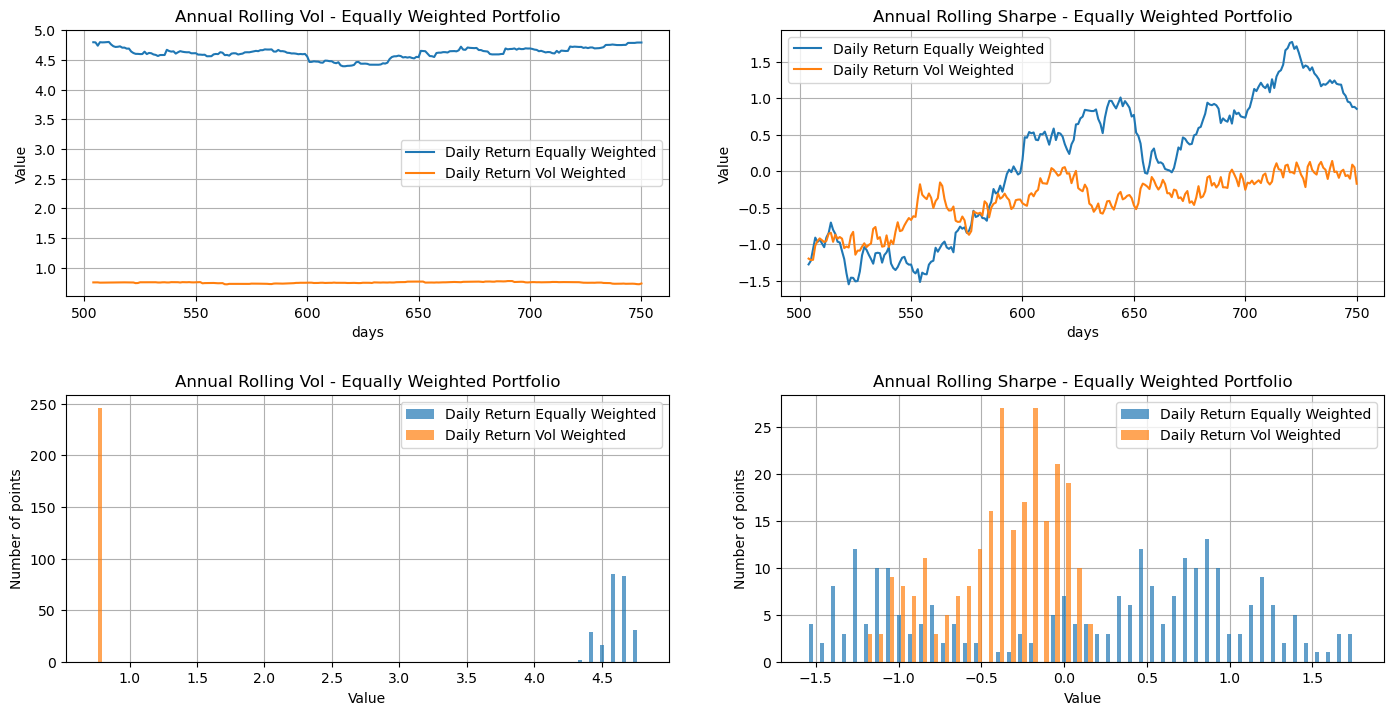

In [44]:
df1 = rolling_vol_eq_weighted_ptf
df2 = rolling_sharpe_eq_weighted_ptf
title1 = "Annual Rolling Vol - Equally Weighted Portfolio"
title2 = "Annual Rolling Sharpe - Equally Weighted Portfolio"
plot_2_dataframes(df1, df2, title1, title2)

Equally Weighted Portfolio performs better than Vol Weighted Portfolio.\
In fact, in the Vol Weighted Portfolio, there are high weights on 3-4 stocks with really low vol which explains its poor performance.

#### Trading Metrics 

Comparison of performance and risk of the stocks

In [45]:
window = 6 * 22
metrics = get_metrics(clean_numerical_variable, window)
metrics.style.format(precision=2).background_gradient(cmap='RdYlGn', axis = 1)

array([[<Axes: title={'center': 'Sharpe Ratio'}>,
        <Axes: title={'center': 'Cumul Return'}>,
        <Axes: title={'center': 'Volatility'}>],
       [<Axes: title={'center': 'Hit Ratio'}>,
        <Axes: title={'center': 'Skew Ratio'}>,
        <Axes: title={'center': 'Average Profit'}>],
       [<Axes: title={'center': 'Average Loss'}>,
        <Axes: title={'center': 'Expectancy'}>,
        <Axes: title={'center': 'Profit to drawndown'}>],
       [<Axes: title={'center': 'Calmar Ratio'}>, <Axes: >, <Axes: >]],
      dtype=object)

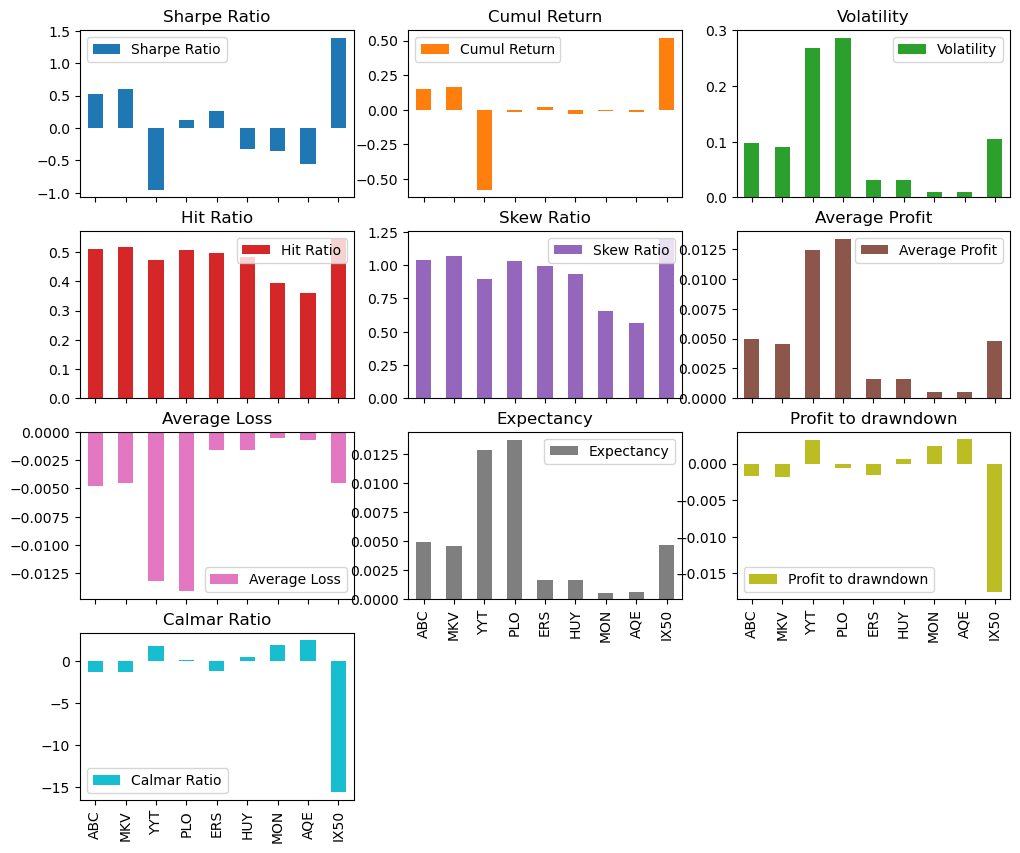

In [46]:
metrics.plot(kind = "bar", subplots = True, layout = (4,3), figsize = (12,10), grid = False)

## II -  Systematic Trading Strategies

According to the assignment, we have a cash nominal of $1,000,000 at inception, and we can solely implement long-only strategies.

In [47]:
nominal = 1000000
short_possible = 0

### 1) Example

We implement Mean Reversion trading strategies for the two benchmarks, by setting up the window and the threshold of the activation functions, either double step  or sigmoid.

#### Equally Weighted - Mean Reversion Trading - Double Step Activation 

In [48]:
df = clean_numerical_variable
window = 22
threshold = 1.96
double_step_eq_portfolio_return, double_step_eq_portfolio_cumul_return = eq_weighted_mean_reverting_double_step(df, window, threshold, nominal)

#### Vol Weighted - Mean Reversion Trading - Double Step Activation 

In [49]:
df = clean_numerical_variable
window = 22
threshold = 1.96
double_step_vol_portfolio_return, double_step_vol_portfolio_cumul_return = vol_weighted_mean_reverting_double_step(df, window, threshold, nominal)

#### Equally Weighted - Mean Reversion Trading - Sigmoid Activation 

In [50]:
df = clean_numerical_variable
window = 22
threshold = 0.5
sigmoid_eq_portfolio_return, sigmoid_eq_portfolio_cumul_return = eq_weighted_mean_reverting_sigmoid(df, window, threshold, nominal)

#### Vol Weighted - Mean Reversion Trading - Sigmoid Activation 

In [51]:
df = clean_numerical_variable
window = 22
threshold = 0.5
sigmoid_vol_portfolio_return, sigmoid_vol_portfolio_cumul_return = vol_weighted_mean_reverting_sigmoid(df, window, threshold, nominal)

#### Systematic Strategies + Benchmarks

Let's compare the performance of these first four strategies to the two benchmarks we built previously.

In [52]:
systematic_strategies = pd.concat([double_step_eq_portfolio_cumul_return,
                                   double_step_vol_portfolio_cumul_return,
                                   sigmoid_eq_portfolio_cumul_return,
                                   sigmoid_vol_portfolio_cumul_return, 
                                   cumul_return_benchmarks], axis = 1)

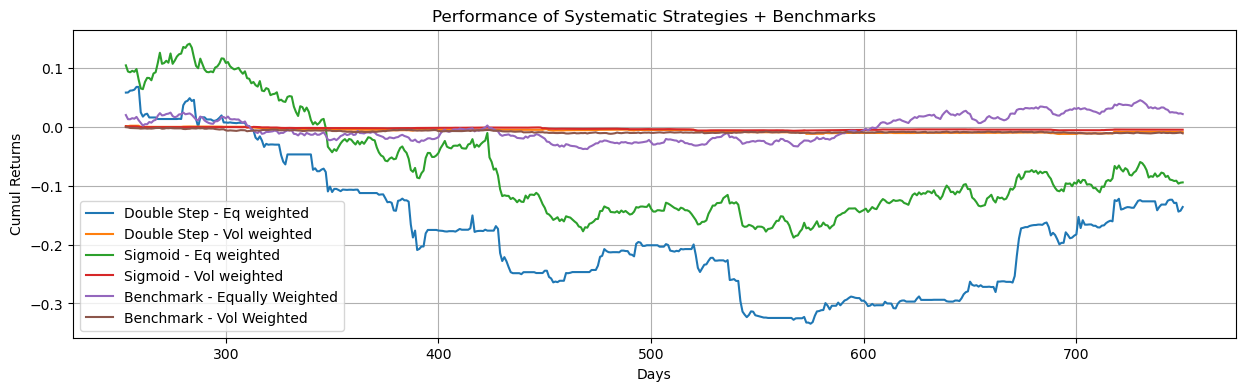

In [53]:
fig, ax = plt.subplots(figsize = (15, 4))
ax.plot(systematic_strategies.dropna(), label = systematic_strategies.columns)
ax.set_title("Performance of Systematic Strategies + Benchmarks")
ax.set_xlabel("Days")
ax.set_ylabel("Cumul Returns")
ax.legend()
ax.grid()

Equally Weighted Portfolio performs better than Vol Weighted Portfolio.\
In fact, in the Vol Weighted Portfolio, there are high weights on 3-4 stocks with really low vol which explains its poor performance.

### TRAIN + TEST

In [54]:
clean_numerical_variable_train, clean_numerical_variable_test = train_test_split(clean_numerical_variable, test_size=0.3, shuffle=False)

### 2) Optimisations - Train

We train each systematic trading strategy by varying hyperparameters to find the optimal training model.

#### Equally Weighted - Mean Reversion Trading - Double Step Activation 

In [55]:
df = clean_numerical_variable_train
list_threshold_range = list(np.arange(0.15, 3, 0.15))
list_window_range = list(np.arange(10, 250, 10))

In [56]:
sharpe_data = pd.DataFrame([])
for window in list_window_range : 
    dict_sharpe_threshold = {}
    for threshold in list_threshold_range :
        double_step_eq_portfolio_return, double_step_eq_portfolio_cumul_return = eq_weighted_mean_reverting_double_step(df, window, threshold, nominal)
        double_step_eq_portfolio_1 = (1 + double_step_eq_portfolio_return).cumprod()
        dict_sharpe_threshold[str(round(threshold,2))] = get_sharpe_ratio(double_step_eq_portfolio_1)

    sharpe_threshold_data = pd.DataFrame.from_dict(dict_sharpe_threshold, orient = "index")
    sharpe_threshold_data.columns = [window]
    
    sharpe_data = pd.concat([sharpe_data, sharpe_threshold_data], axis = 1)
    
sharpe_data = sharpe_data.dropna(axis = 0, how = "all").dropna(axis = 1, how = "all")

In [57]:
sharpe_data.style.format(precision=2).background_gradient(cmap='RdYlGn', axis = 0)

In [58]:
window_train_max_double_step_eq= sharpe_data[sharpe_data == sharpe_data.max().max()].dropna(how = "all", axis = 1).dropna(how = "all", axis = 0).columns[0]
threshold_train_max_double_step_eq = float(sharpe_data[sharpe_data == sharpe_data.max().max()].dropna(how = "all", axis = 1).dropna(how = "all", axis = 0).index[0])

print("Sharpe max: ",round(sharpe_data.max().max(),2))
print("Window: ",window_train_max_double_step_eq)
print("Threshold: ",threshold_train_max_double_step_eq)

Sharpe max:  0.89
Window:  160
Threshold:  2.25


#### Vol Weighted - Mean Reversion Trading - Double Step Activation 

In [59]:
df = clean_numerical_variable_train
list_threshold_range = list(np.arange(0.15, 3, 0.1))
list_window_range = list(np.arange(10, 250, 10))

In [60]:
sharpe_data = pd.DataFrame([])
for window in list_window_range : 
    dict_sharpe_threshold = {}
    for threshold in list_threshold_range :
        double_step_vol_portfolio_return, double_step_vol_portfolio_cumul_return = vol_weighted_mean_reverting_double_step(df, window, threshold, nominal)
        double_step_vol_portfolio_1 = (1 + double_step_vol_portfolio_return).cumprod()
        dict_sharpe_threshold[str(round(threshold,2))] = get_sharpe_ratio(double_step_vol_portfolio_1)

    sharpe_threshold_data = pd.DataFrame.from_dict(dict_sharpe_threshold, orient = "index")
    sharpe_threshold_data.columns = [window]
    
    sharpe_data = pd.concat([sharpe_data, sharpe_threshold_data], axis = 1)
    
sharpe_data = sharpe_data.dropna(axis = 0, how = "all").dropna(axis = 1, how = "all")

In [61]:
sharpe_data.style.format(precision=2).background_gradient(cmap='RdYlGn')

In [62]:
window_train_max_double_step_vol = sharpe_data[sharpe_data == sharpe_data.max().max()].dropna(how = "all", axis = 1).dropna(how = "all", axis = 0).columns[0]
threshold_train_max_double_step_vol = float(sharpe_data[sharpe_data == sharpe_data.max().max()].dropna(how = "all", axis = 1).dropna(how = "all", axis = 0).index[0])

print("Sharpe max: ",round(sharpe_data.max().max(),2))
print("Window: ",window_train_max_double_step_vol)
print("Threshold: ",threshold_train_max_double_step_vol)

Sharpe max:  1.24
Window:  100
Threshold:  1.15


#### Equally Weighted - Mean Reversion Trading - Sigmoid Activation 

In [63]:
df = clean_numerical_variable_train
list_threshold_range = list(np.arange(0.05, 0.9, 0.05))
list_window_range = list(np.arange(10, 250, 10))

In [64]:
sharpe_data = pd.DataFrame([])
for window in list_window_range : 
    dict_sharpe_threshold = {}
    for threshold in list_threshold_range :
        sigmoid_eq_portfolio_return, sigmoid_eq_portfolio_cumul_return = eq_weighted_mean_reverting_sigmoid(df, window, threshold, nominal)
        sigmoid_eq_portfolio_1 = (1 + sigmoid_eq_portfolio_return).cumprod()
        dict_sharpe_threshold[str(round(threshold,2))] = get_sharpe_ratio(sigmoid_eq_portfolio_1)

    sharpe_threshold_data = pd.DataFrame.from_dict(dict_sharpe_threshold, orient = "index")
    sharpe_threshold_data.columns = [window]
    
    sharpe_data = pd.concat([sharpe_data, sharpe_threshold_data], axis = 1)
    
sharpe_data = sharpe_data.dropna(axis = 0, how = "all").dropna(axis = 1, how = "all")

In [65]:
sharpe_data.style.format(precision=2).background_gradient(cmap='RdYlGn')

In [66]:
window_train_max_sigmoid_eq = sharpe_data[sharpe_data == sharpe_data.max().max()].dropna(how = "all", axis = 1).dropna(how = "all", axis = 0).columns[0]
threshold_train_max_sigmoid_eq = float(sharpe_data[sharpe_data == sharpe_data.max().max()].dropna(how = "all", axis = 1).dropna(how = "all", axis = 0).index[0])

print("Sharpe max: ",round(sharpe_data.max().max(),2))
print("Window: ",window_train_max_sigmoid_eq)
print("Threshold: ",threshold_train_max_sigmoid_eq)

Sharpe max:  1.22
Window:  10
Threshold:  0.05


#### Vol Weighted - Mean Reversion Trading - Sigmoid Activation 

In [67]:
df = clean_numerical_variable_train
list_threshold_range = list(np.arange(0.05, 0.9, 0.05))
list_window_range = list(np.arange(10, 250, 10))

In [68]:
sharpe_data = pd.DataFrame([])
for window in list_window_range : 
    dict_sharpe_threshold = {}
    for threshold in list_threshold_range :
        sigmoid_vol_portfolio_return, sigmoid_vol_portfolio_cumul_return = vol_weighted_mean_reverting_sigmoid(df, window, threshold, nominal)
        sigmoid_vol_portfolio_1 = (1 + sigmoid_vol_portfolio_return).cumprod()
        dict_sharpe_threshold[str(round(threshold,2))] = get_sharpe_ratio(sigmoid_vol_portfolio_1)

    sharpe_threshold_data = pd.DataFrame.from_dict(dict_sharpe_threshold, orient = "index")
    sharpe_threshold_data.columns = [window]
    
    sharpe_data = pd.concat([sharpe_data, sharpe_threshold_data], axis = 1)
    
sharpe_data = sharpe_data.dropna(axis = 0, how = "all").dropna(axis = 1, how = "all")

In [69]:
sharpe_data.style.format(precision=2).background_gradient(cmap='RdYlGn')

In [70]:
window_train_max_sigmoid_vol = sharpe_data[sharpe_data == sharpe_data.max().max()].dropna(how = "all", axis = 1).dropna(how = "all", axis = 0).columns[0]
threshold_train_max_sigmoid_vol = float(sharpe_data[sharpe_data == sharpe_data.max().max()].dropna(how = "all", axis = 1).dropna(how = "all", axis = 0).index[0])

print("Sharpe max: ",round(sharpe_data.max().max(),2))
print("Window: ",window_train_max_sigmoid_vol)
print("Threshold: ",threshold_train_max_sigmoid_vol)

Sharpe max:  1.17
Window:  90
Threshold:  0.05


### 3) Train Optimised

Let's take the window and the threshold of the optimised train model to run our systematic strategies.

#### Equally Weighted - Mean Reversion Trading - Double Step Activation

In [71]:
df = clean_numerical_variable_train
window = window_train_max_double_step_eq
threshold = threshold_train_max_double_step_eq
double_step_eq_portfolio_return, double_step_eq_portfolio_cumul_return = eq_weighted_mean_reverting_double_step(df, window, threshold, nominal)

In [72]:
double_step_eq_portfolio_1 = (1 + double_step_eq_portfolio_return).cumprod()
double_step_eq_portfolio_sharpe = get_sharpe_ratio(double_step_eq_portfolio_1)
print("Sharpe :", double_step_eq_portfolio_sharpe)

Sharpe : 0.8949323921353369


#### Vol Weighted - Mean Reversion Trading - Double Step Activation 

In [73]:
df = clean_numerical_variable_train
window = window_train_max_double_step_vol
threshold = threshold_train_max_double_step_vol
double_step_vol_portfolio_return, double_step_vol_portfolio_cumul_return = vol_weighted_mean_reverting_double_step(df, window, threshold, nominal)

In [74]:
double_step_vol_portfolio_1 = (1 + double_step_vol_portfolio_return).cumprod()
double_step_vol_portfolio_sharpe = get_sharpe_ratio(double_step_vol_portfolio_1)
print("Sharpe :", double_step_vol_portfolio_sharpe)

Sharpe : 1.2363781425758167


#### Equally Weighted - Mean Reversion Trading - Sigmoid Activation 

In [75]:
df = clean_numerical_variable_train
window = window_train_max_sigmoid_eq
threshold = threshold_train_max_sigmoid_eq
sigmoid_eq_portfolio_return, sigmoid_eq_portfolio_cumul_return = eq_weighted_mean_reverting_sigmoid(df, window, threshold, nominal)

In [76]:
sigmoid_eq_portfolio_1 = (1 + sigmoid_eq_portfolio_return).cumprod()
sigmoid_eq_portfolio_sharpe = get_sharpe_ratio(sigmoid_eq_portfolio_1)
print("Sharpe :", sigmoid_eq_portfolio_sharpe)

Sharpe : 1.2242990420374886


#### Vol Weighted - Mean Reversion Trading - Sigmoid Activation 

In [77]:
df = clean_numerical_variable_train
window = window_train_max_sigmoid_vol
threshold = threshold_train_max_sigmoid_vol
sigmoid_vol_portfolio_return, sigmoid_vol_portfolio_cumul_return = vol_weighted_mean_reverting_sigmoid(df, window, threshold, nominal)

In [78]:
sigmoid_vol_portfolio_1 = (1 + sigmoid_vol_portfolio_return).cumprod()
sigmoid_vol_portfolio_sharpe = get_sharpe_ratio(sigmoid_vol_portfolio_1)
print("Sharpe :", sigmoid_vol_portfolio_sharpe)

Sharpe : 1.1747149835937447


#### Systematic Strategies + Benchmarks

In [79]:
systematic_strategies = pd.concat([double_step_eq_portfolio_cumul_return,
                                   double_step_vol_portfolio_cumul_return,
                                   sigmoid_eq_portfolio_cumul_return,
                                   sigmoid_vol_portfolio_cumul_return, 
                                   cumul_return_benchmarks], axis = 1)

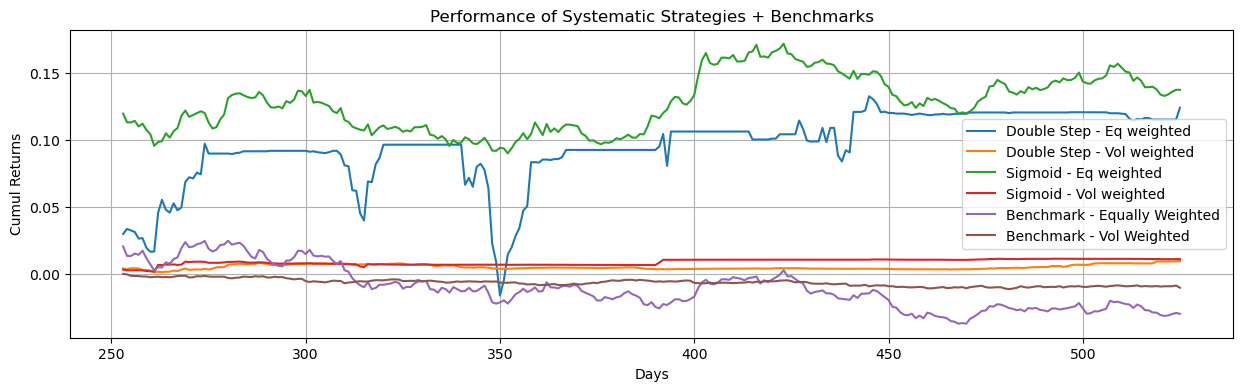

In [80]:
fig, ax = plt.subplots(figsize = (15, 4))
ax.plot(systematic_strategies.dropna(), label = systematic_strategies.columns)
ax.set_title("Performance of Systematic Strategies + Benchmarks")
ax.set_xlabel("Days")
ax.set_ylabel("Cumul Returns")
ax.legend()
ax.grid()

In [81]:
#get strategy metrics
strategy_values_train = get_portfolio_value(systematic_strategies.dropna())
strategy_metrics_train = get_metrics(strategy_values_train, window_value)
strategy_metrics_train

Sharpe Ratio  Cumul Return  Volatility  \
Double Step - Eq weighted         0.823899      0.091801    0.105924   
Double Step - Vol weighted        1.018464      0.005495    0.005016   
Sigmoid - Eq weighted             0.307728      0.015894    0.052030   
Sigmoid - Vol weighted            1.083248      0.007788    0.006680   
Benchmark - Equally Weighted     -1.154741     -0.049383    0.040085   
Benchmark - Vol Weighted         -1.260150     -0.010327    0.007637   

                              Hit Ratio  Skew Ratio  Average Profit  \
Double Step - Eq weighted      0.228782    0.296651        0.006624   
Double Step - Vol weighted     0.512915    1.053030        0.000198   
Sigmoid - Eq weighted          0.479705    0.921986        0.002660   
Sigmoid - Vol weighted         0.476015    0.908451        0.000151   
Benchmark - Equally Weighted   0.472325    0.895105        0.001873   
Benchmark - Vol Weighted       0.531365    1.133858        0.000308   

                              Average Loss  Expectancy  Profit to drawndown  \
Double Step - Eq weighted        -0.005111    0.005457            -0.028858   
Double Step - Vol weighted       -0.000166    0.000182            -0.020197   
Sigmoid - Eq weighted            -0.002330    0.002489            -0.001425   
Sigmoid - Vol weighted           -0.000082    0.000115            -0.071757   
Benchmark - Equally Weighted     -0.002025    0.001953             0.004591   
Benchmark - Vol Weighted         -0.000430    0.000365             0.005802   

                              Calmar Ratio  
Double Step - Eq weighted        -7.649735  
Double Step - Vol weighted       -5.474785  
Sigmoid - Eq weighted            -0.356396  
Sigmoid - Vol weighted          -19.461606  
Benchmark - Equally Weighted      1.234381  
Benchmark - Vol Weighted          1.568837

### 4) Test (with Optimisation from the Train)

#### Equally Weighted - Mean Reversion Trading - Double Step Activation

In [82]:
df = clean_numerical_variable_test
window = window_train_max_double_step_eq
threshold = threshold_train_max_double_step_eq
double_step_eq_portfolio_return, double_step_eq_portfolio_cumul_return = eq_weighted_mean_reverting_double_step(df, window, threshold, nominal)

In [83]:
double_step_eq_portfolio_1 = (1 + double_step_eq_portfolio_return).cumprod()
double_step_eq_portfolio_sharpe = get_sharpe_ratio(double_step_eq_portfolio_1)
print("Sharpe :", double_step_eq_portfolio_sharpe)

Sharpe : 0.48006180575302027


#### Vol Weighted - Mean Reversion Trading - Double Step Activation 

In [84]:
df = clean_numerical_variable_test
window = window_train_max_double_step_vol
threshold = threshold_train_max_double_step_vol
double_step_vol_portfolio_return, double_step_vol_portfolio_cumul_return = vol_weighted_mean_reverting_double_step(df, window, threshold, nominal)

In [85]:
double_step_vol_portfolio_1 = (1 + double_step_vol_portfolio_return).cumprod()
double_step_vol_portfolio_sharpe = get_sharpe_ratio(double_step_vol_portfolio_1)
print("Sharpe :", double_step_vol_portfolio_sharpe)

Sharpe : -1.3133265174675037


#### Equally Weighted - Mean Reversion Trading - Sigmoid Activation 

In [86]:
df = clean_numerical_variable_test
window = window_train_max_sigmoid_eq
threshold = threshold_train_max_sigmoid_eq
sigmoid_eq_portfolio_return, sigmoid_eq_portfolio_cumul_return = eq_weighted_mean_reverting_sigmoid(df, window, threshold, nominal)

In [87]:
sigmoid_eq_portfolio_1 = (1 + sigmoid_eq_portfolio_return).cumprod()
sigmoid_eq_portfolio_sharpe = get_sharpe_ratio(sigmoid_eq_portfolio_1)
print("Sharpe :", sigmoid_eq_portfolio_sharpe)

Sharpe : 1.2301844900997574


#### Vol Weighted - Mean Reversion Trading - Sigmoid Activation 

In [88]:
df = clean_numerical_variable_test
window = window_train_max_sigmoid_vol
threshold = threshold_train_max_sigmoid_vol
sigmoid_vol_portfolio_return, sigmoid_vol_portfolio_cumul_return = vol_weighted_mean_reverting_sigmoid(df, window, threshold, nominal)

In [89]:
sigmoid_vol_portfolio_1 = (1 + sigmoid_vol_portfolio_return).cumprod()
sigmoid_vol_portfolio_sharpe = get_sharpe_ratio(sigmoid_vol_portfolio_1)
print("Sharpe :", sigmoid_vol_portfolio_sharpe)

Sharpe : 0.6831961349629371


#### Systematic Strategies + Benchmarks

In [90]:
systematic_strategies = pd.concat([double_step_eq_portfolio_cumul_return,
                                   double_step_vol_portfolio_cumul_return,
                                   sigmoid_eq_portfolio_cumul_return,
                                   sigmoid_vol_portfolio_cumul_return, 
                                   cumul_return_benchmarks], axis = 1)

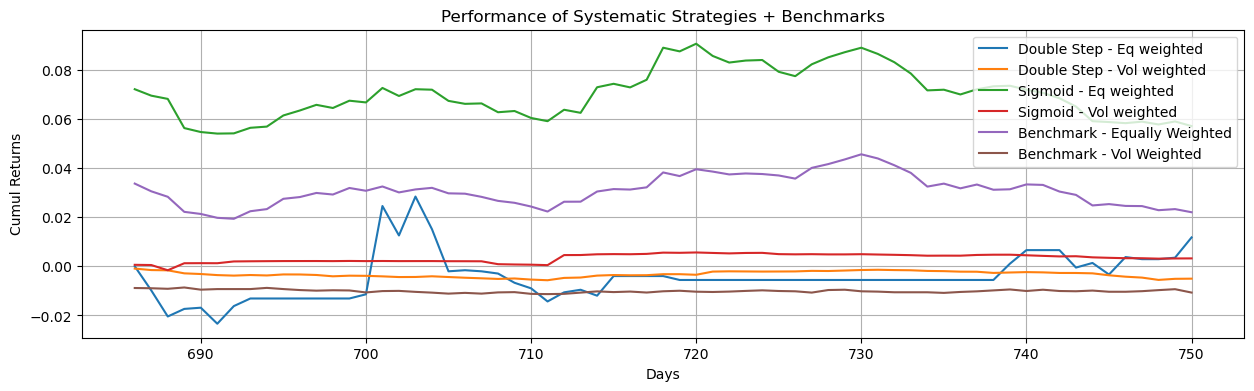

In [91]:
fig, ax = plt.subplots(figsize = (15, 4))
ax.plot(systematic_strategies.dropna(), label = systematic_strategies.columns)
ax.set_title("Performance of Systematic Strategies + Benchmarks")
ax.set_xlabel("Days")
ax.set_ylabel("Cumul Returns")
ax.legend()
ax.grid()

In [92]:
#get strategy metrics
strategy_values_test = get_portfolio_value(systematic_strategies.dropna())
strategy_metrics_test = get_metrics(strategy_values_test, window_value)
strategy_metrics_test

Sharpe Ratio  Cumul Return  Volatility  \
Double Step - Eq weighted         0.480062      0.011753    0.107607   
Double Step - Vol weighted       -2.579690     -0.004108    0.006275   
Sigmoid - Eq weighted            -0.976024     -0.013998    0.055322   
Sigmoid - Vol weighted            0.901881      0.002612    0.011461   
Benchmark - Equally Weighted     -1.238057     -0.011287    0.035596   
Benchmark - Vol Weighted         -1.063816     -0.001872    0.006913   

                              Hit Ratio  Skew Ratio  Average Profit  \
Double Step - Eq weighted      0.265625    0.361702        0.006544   
Double Step - Vol weighted     0.390625    0.641026        0.000281   
Sigmoid - Eq weighted          0.453125    0.828571        0.002515   
Sigmoid - Vol weighted         0.484375    0.939394        0.000327   
Benchmark - Equally Weighted   0.421875    0.729730        0.001866   
Benchmark - Vol Weighted       0.468750    0.882353        0.000341   

                              Average Loss  Expectancy  Profit to drawndown  \
Double Step - Eq weighted        -0.006134    0.006243            -0.004936   
Double Step - Vol weighted       -0.000286    0.000284             0.013529   
Sigmoid - Eq weighted            -0.002476    0.002494             0.006970   
Sigmoid - Vol weighted           -0.000228    0.000276            -0.016389   
Benchmark - Equally Weighted     -0.001664    0.001749             0.007752   
Benchmark - Vol Weighted         -0.000356    0.000349             0.010723   

                              Calmar Ratio  
Double Step - Eq weighted        -0.282983  
Double Step - Vol weighted        0.865167  
Sigmoid - Eq weighted             0.455330  
Sigmoid - Vol weighted           -1.043663  
Benchmark - Equally Weighted      0.500325  
Benchmark - Vol Weighted          0.687811

## III - Machine Learning Models

### 1) OLS

In [93]:
# Correlation Matrix
numerical_corr = clean_numerical_variable.pct_change().corr()

# Correlation Matrix - Select Correl Value according to Threshold
threshold_correl = 0.1
positive_correl = numerical_corr[(numerical_corr > threshold_correl) & (numerical_corr < 1)]
negative_correl = numerical_corr[(numerical_corr < - threshold_correl) & (numerical_corr > - 1)]

#Rolling Correlation
window_value = 22
res_positive = get_correlation_timeseries(clean_numerical_variable, positive_correl, window_value)
res_negative = get_correlation_timeseries(clean_numerical_variable, negative_correl, window_value)

In [94]:
res_pos_neg = list(res_negative.columns) + list(res_positive.columns)
list_stocks_columns = [column.split("_") for column in res_pos_neg]

In [95]:
percentage_test = 0.2
r2_stocks = r2_correl_names(list_stocks_columns, percentage_test)
residuals_stocks = residuals_correl_names(list_stocks_columns, percentage_test)

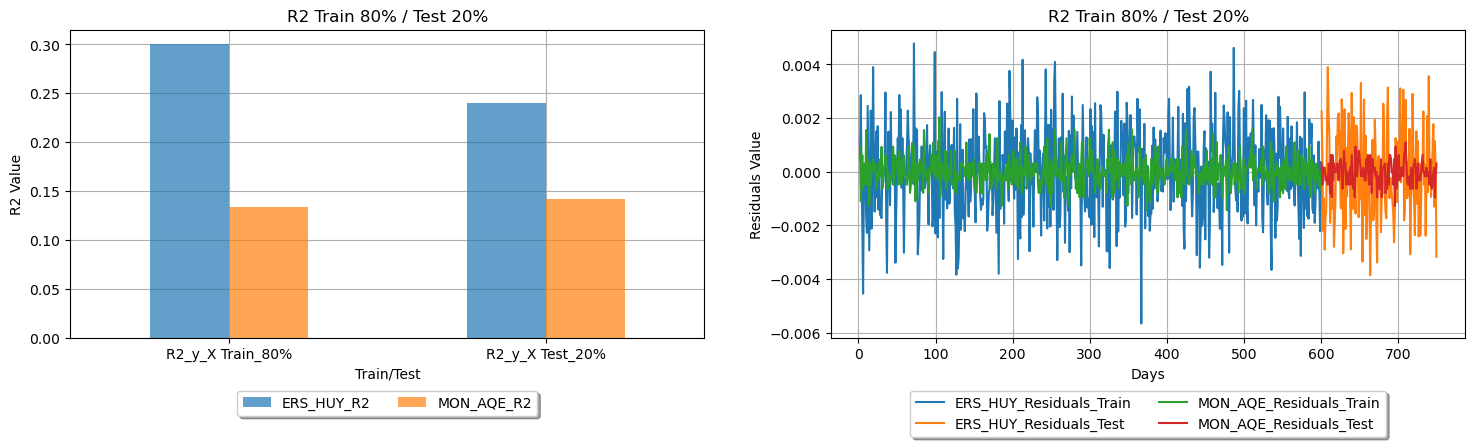

In [96]:
#Plot
fig, axs = plt.subplots(1, 2, figsize = (18,4))

#R2 Score
r2_stocks.plot(kind = "bar", rot = 0, ax = axs[0], alpha = 0.7)
axs[0].set_title("R2 Train " + str(int(100 - percentage_test*100)) + "% / Test " + str(int(percentage_test*100))+"%")
axs[0].set_xlabel("Train/Test")
axs[0].set_ylabel("R2 Value")
axs[0].legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, shadow = True, ncol = 4)
axs[0].grid()
axs[0].set_axisbelow(True)

#Residuals
axs[1].plot(residuals_stocks, label = residuals_stocks.columns)
axs[1].set_title("R2 Train " + str(int(100 - percentage_test*100)) + "% / Test " + str(int(percentage_test*100))+"%")
axs[1].set_xlabel("Days")
axs[1].set_ylabel("Residuals Value")
axs[1].legend(loc='upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, shadow = True, ncol = 2)
axs[1].grid()


#### Double Step Function

In [97]:
threshold = 0
long_positions_data, short_positions_data = get_positions_double_step(residuals_stocks, - threshold, threshold)
positions = long_positions_data.fillna(0) + short_positions_data.fillna(0)
positions_restricted = short_constraints(positions)

In [98]:
cumul_return_correl = pd.DataFrame([])

for column in positions_restricted.columns : 
    residuals_y_X = residuals_stocks[column].dropna()
    positions_residuals_y_X = positions_restricted[column][residuals_y_X.index]
    y_name = column.split("_")[0]
    X_name = column.split("_")[1]
    train_or_test = column.split("_")[3]
    daily_return_y_X = clean_numerical_variable[y_name].pct_change() * positions_residuals_y_X.shift(1)
    daily_return_y_X = daily_return_y_X.to_frame(name = y_name +"_" + X_name + "_" + train_or_test)
    cumul_return_y_X = (1 + daily_return_y_X).cumprod() - 1

    cumul_return_correl = pd.concat([cumul_return_correl, cumul_return_y_X], axis = 1)

<Axes: xlabel='Day'>

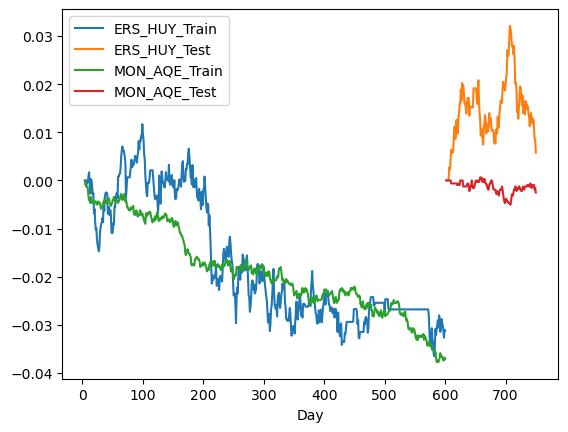

In [99]:
cumul_return_correl.plot()

**Trading metrics of OLS strategies**

In [100]:
strategy_train = get_portfolio_value(cumul_return_correl[["ERS_HUY_Train","MON_AQE_Train"]].dropna())
metrics_train = get_metrics(strategy_train, window_value)
metrics_train

Sharpe Ratio  Cumul Return  Volatility  Hit Ratio  Skew Ratio  \
ERS_HUY_Train     -0.490339     -0.031193    0.026692   0.375421    0.601078   
MON_AQE_Train     -1.769217     -0.037115    0.009046   0.350168    0.538860   

               Average Profit  Average Loss  Expectancy  Profit to drawndown  \
ERS_HUY_Train        0.001497     -0.001586    0.001553             0.005188   
MON_AQE_Train        0.000519     -0.000599    0.000571             0.011184   

               Calmar Ratio  
ERS_HUY_Train      3.116082  
MON_AQE_Train      6.535890

In [101]:
strategy_test = get_portfolio_value(cumul_return_correl[["ERS_HUY_Test","MON_AQE_Test"]].dropna())
metrics_test = get_metrics(strategy_test, window_value)
metrics_test

Sharpe Ratio  Cumul Return  Volatility  Hit Ratio  Skew Ratio  \
ERS_HUY_Test      0.346063      0.005777    0.029599   0.425676    0.741176   
MON_AQE_Test     -0.582220     -0.002522    0.007339   0.297297    0.423077   

              Average Profit  Average Loss  Expectancy  Profit to drawndown  \
ERS_HUY_Test        0.001785     -0.001613    0.001686            -0.002379   
MON_AQE_Test        0.000531     -0.000507    0.000514             0.008966   

              Calmar Ratio  
ERS_HUY_Test     -0.338038  
MON_AQE_Test      1.333647

#### Robustness Check Train/Test OLS

In [102]:
#Robustness Check Train/Test
res_pos_neg = list(res_negative.columns) + list(res_positive.columns)
list_stocks_columns = [column.split("_") for column in res_pos_neg]
list_percentage_test = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

#Try Different Train/Test to see if there is overfit/underfit
r2_test_train = pd.DataFrame([])
for percentage_test in list_percentage_test :
    r2_data = r2_correl_names(list_stocks_columns, percentage_test)
    r2_test_train = pd.concat([r2_test_train, r2_data], axis = 0)

In [103]:
r2_test_train.style.format(precision=4)

### 2) Log Reg

We run a logistic regression using encoded MacroEnvironment as explanatory variable and returns of stocks as dependent variable. Once the model is fitted, we run the analysis on several resampled data.

In [104]:
x_df = clean_categorical_variable["Macro Environment"].to_frame("Macro Environment")
y_df = clean_numerical_variable
auc_stocks = auc_stocks_logreg_resampled(y_df, x_df)
auc_stocks.style.format(precision=2).background_gradient(cmap='RdYlGn')

With an AUC close to 0.5 for every stock, we cannot use the logistic regression to find a link between macro environment and stock's returns as its predictive ability is no better than random guessing.